In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pandas numpy torch torch-geometric scikit-learn matplotlib optuna tensorflow keras-tuner scipy tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
import pandas as pd
import numpy as np
import torch
import gc
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from scipy.spatial import cKDTree
from torch_geometric.nn import SAGEConv
import torch.optim as optim
from tqdm import tqdm
from tensorflow.keras.models import load_model
import os

file_path = '/content/drive/MyDrive/THESIS/Train_model_london_Vince.csv'
full_train_data = pd.read_csv(file_path)


file_path = '/content/drive/MyDrive/THESIS/Valid_model_london_Vince.csv'
full_valid_data = pd.read_csv(file_path)


file_path = '/content/drive/MyDrive/THESIS/Test_model_london_Vince.csv'
full_test_data = pd.read_csv(file_path)

In [ ]:
train_data = full_train_data.copy()
val_data = full_valid_data.copy()
test_data = full_test_data.copy()

# Preprocess function
def preprocess_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    return data

train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)
test_data = preprocess_data(test_data)

This section describes the creation of the LSTM model. Only the 'id,' 'date,' and 'price' columns are used here. The model then creates sequences of historical prices to learn temporal features that can contribute to predictive performance. The model is also hyperparameter-tuned using Optuna. Two additional variables that are tuned, besides the hyperparameters of the LSTM model itself, are 'sequence_length' and 'max_instances_per_location.'

The sequence length determines the size of the price sequences used to learn features. The max_instances_per_location parameter selects a certain number of random historical prices per unique location since using all historical prices would require too much computational power. The learned features are extracted, and the model is saved for later reuse. The max_instances_per_location is set to 100, as this has already been adjusted in the dataset, but it is kept in place just in case.

In [ ]:
import optuna
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
from google.colab import drive
import joblib

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = RobustScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

# Sequence creation function
def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(sequence_length, len(group)):
            seq = group.iloc[i-sequence_length:i]
            sequences.append(seq)
            labels.append(group.iloc[i]['price'])  # Correct label
            ids.append(id)
    return sequences, labels, ids

# Define the objective function for Optuna
def objective(trial):
    sequence_length = trial.suggest_int('sequence_length', 7, 14)
    max_instances_per_location = trial.suggest_int('max_instances_per_location', 100, 100, step=25)

    train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, sequence_length, max_instances_per_location)
    val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, sequence_length, max_instances_per_location)
    test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, sequence_length, max_instances_per_location)

    X_train = np.array([seq[['price']].values for seq in train_sequences])
    y_train = np.array(train_labels)
    X_val = np.array([seq[['price']].values for seq in val_sequences])
    y_val = np.array(val_labels)
    X_test = np.array([seq[['price']].values for seq in test_sequences])
    y_test = np.array(test_labels)

    model = Sequential()
    model.add(LSTM(units=trial.suggest_int('units1', 32, 128, step=32),
                   return_sequences=True,
                   input_shape=(sequence_length, 1), activation='relu'))
    model.add(Dropout(rate=trial.suggest_float('dropout1', 0.2, 0.5, step=0.1)))
    model.add(LSTM(units=trial.suggest_int('units2', 32, 128, step=32), return_sequences=False, activation='relu'))
    model.add(Dropout(rate=trial.suggest_float('dropout2', 0.2, 0.5, step=0.1)))
    model.add(Dense(16))
    model.add(Dense(1))

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mse'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping], verbose=0)

    val_loss = min(history.history['val_loss'])

    # Save the model
    model_save_path = os.path.join(drive_path, f'model_trial_{trial.number}.h5')
    model.save(model_save_path)

    return val_loss

# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_trial = study.best_trial

# Extract the best hyperparameters
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']
best_units1 = best_trial.params['units1']
best_units2 = best_trial.params['units2']
best_dropout1 = best_trial.params['dropout1']
best_dropout2 = best_trial.params['dropout2']
best_learning_rate = best_trial.params['learning_rate']

# Recreate sequences with the best sequence length
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values for seq in train_sequences])
y_train = np.array(train_labels)
X_val = np.array([seq[['price']].values for seq in val_sequences])
y_val = np.array(val_labels)
X_test = np.array([seq[['price']].values for seq in test_sequences])
y_test = np.array(test_labels)

# Build the final model using the best hyperparameters
input_layer = Input(shape=(best_sequence_length, 1))
lstm_layer_1 = LSTM(units=best_units1, return_sequences=True, activation='relu')(input_layer)
dropout_layer_1 = Dropout(rate=best_dropout1)(lstm_layer_1)
lstm_layer_2 = LSTM(units=best_units2, return_sequences=False, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(rate=best_dropout2)(lstm_layer_2)
dense_layer = Dense(16)(dropout_layer_2)
output_layer = Dense(1)(dense_layer)

feature_extraction_model = Model(inputs=input_layer, outputs=dense_layer)
prediction_model = Model(inputs=input_layer, outputs=output_layer)
prediction_model.compile(optimizer=Adam(learning_rate=best_learning_rate),
                         loss='mean_squared_error',
                         metrics=['mse'])

history = prediction_model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), batch_size=32)

# Save the final model
final_model_path = os.path.join(drive_path, 'LSTM_MODEL_LONDON_FINAL.h5')
prediction_model.save(final_model_path)

feature_model_path = os.path.join(drive_path, 'LSTM_FEATURES_LONDON_FINAL.h5')
feature_extraction_model.save(feature_model_path)

train_features_lstm = feature_extraction_model.predict(X_train)
val_features_lstm = feature_extraction_model.predict(X_val)
test_features_lstm = feature_extraction_model.predict(X_test)

# Optional: Save the Optuna study
study_path = os.path.join(drive_path, 'optuna_study_LSTM_LONDON_FINAL.pkl')
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

# Optional: Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)


The LSTM model can be reloaded here.


In [ ]:
import os
from tensorflow.keras.models import load_model
import joblib
import optuna
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
from google.colab import drive
import joblib

import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm

# Custom LSTM without the 'time_major' argument
class CustomLSTM(LSTM):
    def __init__(self, *args, **kwargs):
        # Remove time_major if it exists in kwargs
        kwargs.pop('time_major', None)
        super(CustomLSTM, self).__init__(*args, **kwargs)

# Mapping the custom class
custom_objects = {'LSTM': CustomLSTM}

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'

feature_model_path = os.path.join(drive_path, 'LSTM_FEATURES_LONDON_FINAL.h5')
study_path = os.path.join(drive_path, 'optuna_study_LSTM_LONDON_FINAL.pkl')

# Load the model

extraction_model = load_model(feature_model_path, custom_objects=custom_objects)

# Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)

best_trial = loaded_study.best_trial
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = RobustScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i + sequence_length]
            sequences.append(seq)
            labels.append(group.iloc[i + sequence_length])
            ids.append(id)
    return sequences, labels, ids

# Create sequences using the best parameters from Optuna
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values for seq in train_sequences])
y_train = np.array(train_labels)
X_val = np.array([seq[['price']].values for seq in val_sequences])
y_val = np.array(val_labels)
X_test = np.array([seq[['price']].values for seq in test_sequences])
y_test = np.array(test_labels)

# Assuming the loaded model is the feature extraction model
train_features_lstm = extraction_model.predict(X_train)
val_features_lstm = extraction_model.predict(X_val)
test_features_lstm = extraction_model.predict(X_test)



Creating sequences: 100%|██████████| 2000/2000 [00:06<00:00, 317.67it/s]


15179/15179 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Here, the LSTM model can be reloaded to make price predictions.

In [ ]:
import os
from tensorflow.keras.models import load_model
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
import numpy as np
from tqdm import tqdm

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
final_model_path = os.path.join(drive_path, 'LSTM_MODEL_LONDON_FINAL.h5')
study_path = os.path.join(drive_path, 'optuna_study_LSTM_LONDON_FINAL.pkl')

# Load the model
loaded_model = load_model(final_model_path)

# Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)

best_trial = loaded_study.best_trial
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = RobustScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i + sequence_length]
            sequences.append(seq)
            labels.append(group.iloc[i + sequence_length]['price'])
            ids.append(id)
    return sequences, labels, ids

# Create sequences using the best parameters from Optuna
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values for seq in train_sequences])
y_train = np.array(train_labels)
X_val = np.array([seq[['price']].values for seq in val_sequences])
y_val = np.array(val_labels)
X_test = np.array([seq[['price']].values for seq in test_sequences])
y_test = np.array(test_labels)

# Evaluate the model on the test set
evaluation = loaded_model.evaluate(X_test, y_test, verbose=2)

# Make predictions on the test set
y_test_pred = loaded_model.predict(X_test)

# Inverse transform the predictions and true values
y_test_pred_unscaled = scaler.inverse_transform(y_test_pred)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate and display the MSE, MAE, and R-squared metrics
mse = mean_squared_error(y_test_unscaled, y_test_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_test_pred_unscaled)
r2 = r2_score(y_test_unscaled, y_test_pred_unscaled)
avg_residuals = np.mean(y_test_unscaled - y_test_pred_unscaled)

print("Evaluation - Loss, MSE, MAE:", evaluation)
print("Manual Calculation - Mean Squared Error (MSE):", mse)
print("Manual Calculation - Mean Absolute Error (MAE):", mae)
print("Manual Calculation - R-squared:", r2)
print("Manual Calculation - Average Residuals:", avg_residuals)

Creating sequences: 100%|██████████| 2000/2000 [00:06<00:00, 305.16it/s]


1250/1250 - 4s - 3ms/step - loss: 0.3847 - mean_squared_error: 0.3847
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Evaluation - Loss, MSE, MAE: [0.38465628027915955, 0.38465628027915955]
Manual Calculation - Mean Squared Error (MSE): 4998.991238211012
Manual Calculation - Mean Absolute Error (MAE): 34.352998938804035
Manual Calculation - R-squared: 0.7535561403663469
Manual Calculation - Average Residuals: -29.28855612480705


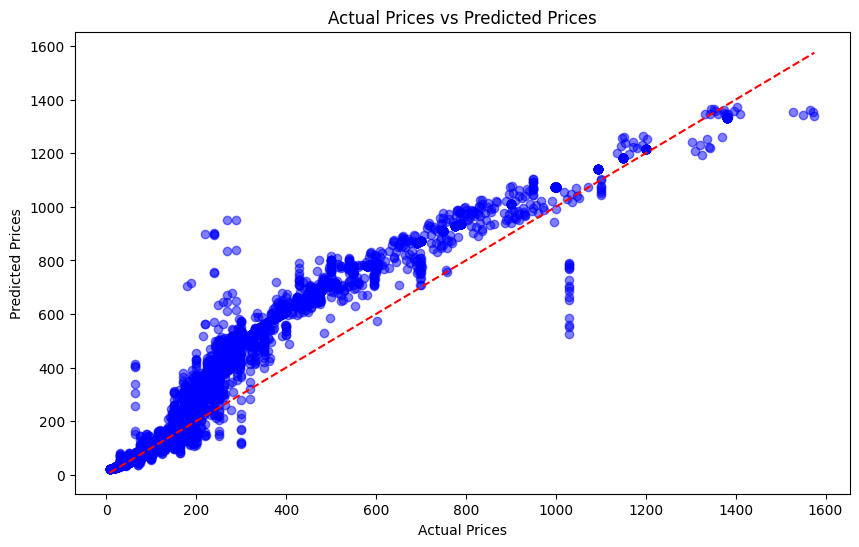

In [ ]:
# Plotting actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test_unscaled, y_test_pred_unscaled, color='blue', alpha=0.5)
plt.plot([min(y_test_unscaled), max(y_test_unscaled)], [min(y_test_unscaled), max(y_test_unscaled)], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual Prices vs Predicted Prices')

plt.show()

In [ ]:
# Unscaling the datasets
train_data_lstm_unscaled = train_data_lstm.copy()
train_data_lstm_unscaled['price'] = scaler.inverse_transform(train_data_lstm[['price']])

val_data_lstm_unscaled = val_data_lstm.copy()
val_data_lstm_unscaled['price'] = scaler.inverse_transform(val_data_lstm[['price']])

test_data_lstm_unscaled = test_data_lstm.copy()
test_data_lstm_unscaled['price'] = scaler.inverse_transform(test_data_lstm[['price']])




Code to correctly merge the LSTM features with the original data.

In [ ]:
train_features_lstm = scaler.inverse_transform(train_features_lstm)
val_features_lstm = scaler.inverse_transform(val_features_lstm)
test_features_lstm = scaler.inverse_transform(test_features_lstm)

In [ ]:
# Convert the extracted features and IDs into DataFrames with clean integer IDs
train_features_with_ids = pd.DataFrame(train_features_lstm)
train_features_with_ids['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in train_ids]

val_features_with_ids = pd.DataFrame(val_features_lstm)
val_features_with_ids['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in val_ids]

test_features_with_ids = pd.DataFrame(test_features_lstm)
test_features_with_ids['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in test_ids]

# Now train_features_with_ids, val_features_with_ids, and test_features_with_ids contain the LSTM features and their associated integer IDs


In [ ]:
# Extract the last occurrence of each ID's features
def extract_last_features(features, ids):
    last_features_map = {}
    for idx, id in enumerate(ids):
        last_features_map[id] = features[idx]
    unique_ids = list(last_features_map.keys())
    last_features = np.array([last_features_map[id] for id in unique_ids])
    return last_features, unique_ids

# Apply extraction of the last features
train_last_features, train_unique_ids = extract_last_features(train_features_lstm, train_ids)
val_last_features, val_unique_ids = extract_last_features(val_features_lstm, val_ids)
test_last_features, test_unique_ids = extract_last_features(test_features_lstm, test_ids)

# Convert to DataFrames
train_features_with_ids_last = pd.DataFrame(train_last_features)
train_features_with_ids_last['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in train_unique_ids]

val_features_with_ids_last = pd.DataFrame(val_last_features)
val_features_with_ids_last['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in val_unique_ids]

test_features_with_ids_last = pd.DataFrame(test_last_features)
test_features_with_ids_last['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in test_unique_ids]

In this step, the data is preprocessed for the PE-GNN model. Since historical prices are no longer needed, only one data entry is kept for each unique Airbnb listing. The coordinates are then extracted to be used in the position encoder, and the other hedonic features are combined with the learned LSTM features to be added to the nodes of the GNN. Additionally, it is ensured that the spatial and temporal features, which are used for the baseline models, are removed from the data

In [19]:
import pandas as pd

# Preprocess PE-GNN data and take the last instance for each id
def preprocess_pegnn_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    data = data.drop_duplicates(subset=['id'], keep='last')
    return data

train_data_pegnn = preprocess_pegnn_data(train_data.copy())
val_data_pegnn = preprocess_pegnn_data(val_data.copy())
test_data_pegnn = preprocess_pegnn_data(test_data.copy())



In [20]:

import pandas as pd

# Assume train_data_pegnn, val_data_pegnn, and test_data_pegnn are already loaded and contain the 'id' column

# Ensure IDs are consistent and merge the datasets
train_data_pegnn['id'] = train_data_pegnn['id'].astype(int)
val_data_pegnn['id'] = val_data_pegnn['id'].astype(int)
test_data_pegnn['id'] = test_data_pegnn['id'].astype(int)

train_features_with_ids_last['id'] = train_features_with_ids_last['id'].astype(int)
val_features_with_ids_last['id'] = val_features_with_ids_last['id'].astype(int)
test_features_with_ids_last['id'] = test_features_with_ids_last['id'].astype(int)

# Merge the LSTM features with the original data
train_data_pegnn = pd.merge(train_data_pegnn, train_features_with_ids_last, on='id', how='left')
val_data_pegnn = pd.merge(val_data_pegnn, val_features_with_ids_last, on='id', how='left')
test_data_pegnn = pd.merge(test_data_pegnn, test_features_with_ids_last, on='id', how='left')


In [21]:
from sklearn.preprocessing import StandardScaler, RobustScaler
# Extract features
def extract_features(data):
    coordinates = data[['latitude', 'longitude']].to_numpy()
    # Dropping unnecessary columns including the specified features
    #features = data
    features = data.drop(columns=[
    'latitude', 'longitude', 'date', 'id', 'host_id',
    "nearby_restaurants_bars", "nearby_transport", "mean_price_neighbors",
    "nearby_airbnbs_count",
    "neighbourhood_Barking and Dagenham", "neighbourhood_Barnet", "neighbourhood_Bexley",
    "neighbourhood_Brent", "neighbourhood_Bromley", "neighbourhood_Camden",
    "neighbourhood_City of London", "neighbourhood_Croydon", "neighbourhood_Ealing",
    "neighbourhood_Enfield", "neighbourhood_Greenwich", "neighbourhood_Hackney",
    "neighbourhood_Hammersmith and Fulham", "neighbourhood_Haringey", "neighbourhood_Harrow",
    "neighbourhood_Havering", "neighbourhood_Hillingdon", "neighbourhood_Hounslow",
    "neighbourhood_Islington", "neighbourhood_Kensington and Chelsea",
    "neighbourhood_Kingston upon Thames", "neighbourhood_Lambeth", "neighbourhood_Lewisham",
    "neighbourhood_Merton", "neighbourhood_Newham", "neighbourhood_Redbridge",
    "neighbourhood_Richmond upon Thames", "neighbourhood_Southwark", "neighbourhood_Sutton",
    "neighbourhood_Tower Hamlets", "neighbourhood_Waltham Forest", "neighbourhood_Wandsworth",
    "neighbourhood_Westminster", "season_Autumn", "is_holiday", "is_school_holiday"])


    for col in features.select_dtypes(include=['object']).columns:
        features[col] = features[col].astype('category').cat.codes
    features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
    features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
    non_numeric_cols = features.select_dtypes(exclude=[np.number]).columns.tolist()
    features = features.select_dtypes(include=[np.number])
    print("Dropped non-numeric features:", non_numeric_cols)

    features.columns = features.columns.astype(str)
    return coordinates, features



# Extracting features for train, validation, and test sets
train_coords_pegnn, train_features_pegnn = extract_features(train_data_pegnn)
val_coords_pegnn, val_features_pegnn = extract_features(val_data_pegnn)
test_coords_pegnn, test_features_pegnn = extract_features(test_data_pegnn)

train_prices_pegnn = train_features_pegnn['price'].values
val_prices_pegnn = val_features_pegnn['price'].values
test_prices_pegnn = test_features_pegnn['price'].values



# Scaling combined features
scaler = RobustScaler()
train_features_pegnn = pd.DataFrame(scaler.fit_transform(train_features_pegnn), columns=train_features_pegnn.columns)
val_features_pegnn = pd.DataFrame(scaler.transform(val_features_pegnn), columns=val_features_pegnn.columns)
test_features_pegnn = pd.DataFrame(scaler.transform(test_features_pegnn), columns=test_features_pegnn.columns)

# Initialize and fit the RobustScaler on the training prices
scaler = RobustScaler()
train_prices_pegnn_scaled = scaler.fit_transform(train_prices_pegnn.reshape(-1, 1))
val_prices_pegnn_scaled = scaler.transform(val_prices_pegnn.reshape(-1, 1))
test_prices_pegnn_scaled = scaler.transform(test_prices_pegnn.reshape(-1, 1))


# Convert the scaled prices to PyTorch tensors
y_train = torch.tensor(train_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)
y_val = torch.tensor(val_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(test_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)


<ipython-input-21-9ca89abc452e>:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
<ipython-input-21-9ca89abc452e>:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
<ipython-input-21-9ca89abc452e>:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)


Dropped non-numeric features: []
Dropped non-numeric features: []
Dropped non-numeric features: []


In [ ]:
train_features_pegnn.head()

,available,price,host_response_time,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,...,total_amenities,listing_reviewed,property_type_Apartment,property_type_Hotel,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Private room,luxury_amenities_score,kitchen_amenities
0,0.0,-0.442516,-0.333333,0.0,0.0,-0.25,0.0,-0.5,0.0,0.0,...,1.157895,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,0.333333
1,1.0,-0.373102,0.000000,0.0,5.0,2.50,0.0,0.0,0.0,0.0,...,-0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333
2,1.0,0.433839,-0.333333,0.0,0.0,0.25,-1.0,-0.5,0.0,0.0,...,-0.894737,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0,2.0,-0.666667
3,0.0,-0.503254,-0.333333,0.0,0.0,-0.25,0.0,0.0,1.0,0.0,...,-0.631579,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-0.666667
4,0.0,-0.095445,-0.333333,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,...,0.368421,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.333333


to save the dataset with lstm features

In [ ]:
# Specify the path in Google Drive where you want to save the files
path = '/content/drive/My Drive/THESIS/'

# Save the processed data to CSV files
train_data_pegnn.to_csv(path + 'train_data_lstm_london_FINAL.csv', index=False)
val_data_pegnn.to_csv(path + 'val_data_lstm_london_FINAL.csv', index=False)
test_data_pegnn.to_csv(path + 'test_data_lstm_london_FINAL.csv', index=False)

This section describes the creation of the PE-GNN model. It also includes the functionality to save the model and reuse it later. The edges of the GNN are created using a k-nearest neighbors approach, where edges are formed between the x number of closest neighbors in terms of physical distance. The number of nearest neighbors, along with several other variables, is hyperparameter-tuned using Optuna.

The position encoder learns by utilizing the coordinates of the nodes and adds this information to the nodes. As a result, the nodes contain information about the spatial aspect through the PE, the temporal aspect through the LSTM, and the hedonic features. This model also provides various performance metrics, which can be viewed below, along with several plots to track the evolution of these metrics throughout the learning process.

[I 2024-08-13 12:29:44,115] A new study created in memory with name: no-name-a4c23871-4a19-4b11-9990-6a126f9667ca
Training PEGNN: 100%|██████████| 50/50 [00:04<00:00, 10.79it/s]
[I 2024-08-13 12:29:48,939] Trial 0 finished with value: 0.25566184520721436 and parameters: {'hidden_channels': 100, 'lr': 0.0005265053091323402, 'k': 5, 'dropout_rate': 0.471083049745173}. Best is trial 0 with value: 0.25566184520721436.
Training PEGNN: 100%|██████████| 50/50 [01:37<00:00,  1.95s/it]
[I 2024-08-13 12:31:28,248] Trial 1 finished with value: 0.038797102868556976 and parameters: {'hidden_channels': 120, 'lr': 0.003327615738747813, 'k': 81, 'dropout_rate': 0.12202255207328375}. Best is trial 1 with value: 0.038797102868556976.
Training PEGNN: 100%|██████████| 50/50 [00:52<00:00,  1.06s/it]
[I 2024-08-13 12:32:22,201] Trial 2 finished with value: 0.06636322289705276 and parameters: {'hidden_channels': 66, 'lr': 0.004367609342650717, 'k': 51, 'dropout_rate': 0.30026185738996236}. Best is trial 1 wi

Best parameters:  {'hidden_channels': 116, 'lr': 0.0020366914792635735, 'k': 117, 'dropout_rate': 0.15351297622150523}


Final training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1, Training Loss: 1.7984586954116821, Training R-squared: -0.1693427134696377, Training MAE: 0.7270472645759583, Training MSE: 1.7984586954116821


Final training:   0%|          | 1/500 [00:03<27:24,  3.30s/it]

Epoch 1, Validation Loss: 1.1101901531219482, Validation R-squared: 0.23874223565719732, Validation MAE: 0.653396725654602, Validation MSE: 1.1101901531219482
Epoch 2, Training Loss: 1.123653531074524, Training R-squared: 0.2694099583745295, Training MAE: 0.6761281490325928, Training MSE: 1.123653531074524


Final training:   0%|          | 2/500 [00:06<26:06,  3.14s/it]

Epoch 2, Validation Loss: 0.9584224224090576, Validation R-squared: 0.3428094476790746, Validation MAE: 0.6793631315231323, Validation MSE: 0.9584223628044128
Epoch 3, Training Loss: 1.0569764375686646, Training R-squared: 0.312762755517507, Training MAE: 0.7211363911628723, Training MSE: 1.056976556777954


Final training:   1%|          | 3/500 [00:09<25:44,  3.11s/it]

Epoch 3, Validation Loss: 0.8158172965049744, Validation R-squared: 0.44059377234404284, Validation MAE: 0.6074559688568115, Validation MSE: 0.8158172965049744
Epoch 4, Training Loss: 0.9844118356704712, Training R-squared: 0.35994367303420016, Training MAE: 0.6580122709274292, Training MSE: 0.9844118356704712


Final training:   1%|          | 4/500 [00:12<26:03,  3.15s/it]

Epoch 4, Validation Loss: 0.6735658049583435, Validation R-squared: 0.5381357178829229, Validation MAE: 0.48754173517227173, Validation MSE: 0.6735657453536987
Epoch 5, Training Loss: 0.821704089641571, Training R-squared: 0.4657349867903273, Training MAE: 0.5333665609359741, Training MSE: 0.8217040300369263


Final training:   1%|          | 5/500 [00:15<26:31,  3.21s/it]

Epoch 5, Validation Loss: 0.6085934638977051, Validation R-squared: 0.5826872919061932, Validation MAE: 0.4090737998485565, Validation MSE: 0.6085934042930603
Epoch 6, Training Loss: 0.7030965089797974, Training R-squared: 0.5428525593692732, Training MAE: 0.4422200620174408, Training MSE: 0.7030965089797974


Final training:   1%|          | 6/500 [00:19<26:04,  3.17s/it]

Epoch 6, Validation Loss: 0.5939518809318542, Validation R-squared: 0.5927270002455232, Validation MAE: 0.39104315638542175, Validation MSE: 0.5939518213272095
Epoch 7, Training Loss: 0.5787192583084106, Training R-squared: 0.6237216040155653, Training MAE: 0.3998587727546692, Training MSE: 0.5787192583084106


Final training:   1%|▏         | 7/500 [00:22<25:48,  3.14s/it]

Epoch 7, Validation Loss: 0.5584103465080261, Validation R-squared: 0.6170978365156216, Validation MAE: 0.3834896981716156, Validation MSE: 0.5584103465080261
Epoch 8, Training Loss: 0.5292837023735046, Training R-squared: 0.6558641855306204, Training MAE: 0.38550281524658203, Training MSE: 0.5292837023735046


Final training:   2%|▏         | 8/500 [00:25<25:46,  3.14s/it]

Epoch 8, Validation Loss: 0.48188358545303345, Validation R-squared: 0.6695722647654476, Validation MAE: 0.3582915663719177, Validation MSE: 0.48188355565071106
Epoch 9, Training Loss: 0.47067147493362427, Training R-squared: 0.6939733497610332, Training MAE: 0.36551257967948914, Training MSE: 0.47067150473594666


Final training:   2%|▏         | 9/500 [00:28<26:12,  3.20s/it]

Epoch 9, Validation Loss: 0.3947547674179077, Validation R-squared: 0.7293164914063938, Validation MAE: 0.3263033628463745, Validation MSE: 0.3947548270225525
Epoch 10, Training Loss: 0.38807442784309387, Training R-squared: 0.7476772887683405, Training MAE: 0.3418591320514679, Training MSE: 0.38807442784309387


Final training:   2%|▏         | 10/500 [00:31<25:45,  3.15s/it]

Epoch 10, Validation Loss: 0.3313594460487366, Validation R-squared: 0.7727867066855473, Validation MAE: 0.3129514753818512, Validation MSE: 0.3313594460487366
Epoch 11, Training Loss: 0.3600117862224579, Training R-squared: 0.765923356616868, Training MAE: 0.3440377116203308, Training MSE: 0.3600117862224579


Final training:   2%|▏         | 11/500 [00:34<25:26,  3.12s/it]

Epoch 11, Validation Loss: 0.2997351288795471, Validation R-squared: 0.7944714908085732, Validation MAE: 0.31493866443634033, Validation MSE: 0.2997351586818695
Epoch 12, Training Loss: 0.3696407377719879, Training R-squared: 0.7596626888619443, Training MAE: 0.35352930426597595, Training MSE: 0.3696407973766327


Final training:   2%|▏         | 12/500 [00:37<25:34,  3.14s/it]

Epoch 12, Validation Loss: 0.2736961543560028, Validation R-squared: 0.812326438697361, Validation MAE: 0.3117346167564392, Validation MSE: 0.2736961543560028
Epoch 13, Training Loss: 0.3361477553844452, Training R-squared: 0.7814395754786141, Training MAE: 0.3471391499042511, Training MSE: 0.3361477255821228


Final training:   3%|▎         | 13/500 [00:41<25:47,  3.18s/it]

Epoch 13, Validation Loss: 0.24560220539569855, Validation R-squared: 0.831590491624542, Validation MAE: 0.29786527156829834, Validation MSE: 0.24560219049453735
Epoch 14, Training Loss: 0.33752739429473877, Training R-squared: 0.7805425311071994, Training MAE: 0.331490159034729, Training MSE: 0.33752739429473877


Final training:   3%|▎         | 14/500 [00:44<25:35,  3.16s/it]

Epoch 14, Validation Loss: 0.2284006029367447, Validation R-squared: 0.8433856355856956, Validation MAE: 0.2839033007621765, Validation MSE: 0.2284005880355835
Epoch 15, Training Loss: 0.2885458767414093, Training R-squared: 0.8123898951638963, Training MAE: 0.31186455488204956, Training MSE: 0.2885458767414093


Final training:   3%|▎         | 15/500 [00:47<25:26,  3.15s/it]

Epoch 15, Validation Loss: 0.22492025792598724, Validation R-squared: 0.8457720928579903, Validation MAE: 0.27483734488487244, Validation MSE: 0.22492027282714844
Epoch 16, Training Loss: 0.26728355884552, Training R-squared: 0.8262144996341326, Training MAE: 0.2970949411392212, Training MSE: 0.26728352904319763


Final training:   3%|▎         | 16/500 [00:50<25:34,  3.17s/it]

Epoch 16, Validation Loss: 0.22423678636550903, Validation R-squared: 0.8462407490453089, Validation MAE: 0.26930347084999084, Validation MSE: 0.22423678636550903
Epoch 17, Training Loss: 0.28625619411468506, Training R-squared: 0.8138786421645143, Training MAE: 0.2867031693458557, Training MSE: 0.28625619411468506


Final training:   3%|▎         | 17/500 [00:53<25:47,  3.20s/it]

Epoch 17, Validation Loss: 0.21264490485191345, Validation R-squared: 0.8541893221366761, Validation MAE: 0.26414617896080017, Validation MSE: 0.21264490485191345
Epoch 18, Training Loss: 0.25562697649002075, Training R-squared: 0.8337934988583486, Training MAE: 0.28492313623428345, Training MSE: 0.25562697649002075


Final training:   4%|▎         | 18/500 [00:57<25:33,  3.18s/it]

Epoch 18, Validation Loss: 0.19092732667922974, Validation R-squared: 0.869081082401432, Validation MAE: 0.2597454786300659, Validation MSE: 0.19092731177806854
Epoch 19, Training Loss: 0.24758104979991913, Training R-squared: 0.8390248882421447, Training MAE: 0.28775984048843384, Training MSE: 0.24758103489875793


Final training:   4%|▍         | 19/500 [00:59<25:02,  3.12s/it]

Epoch 19, Validation Loss: 0.1698743999004364, Validation R-squared: 0.8835170485990931, Validation MAE: 0.25959908962249756, Validation MSE: 0.1698744148015976
Epoch 20, Training Loss: 0.2855631411075592, Training R-squared: 0.8143292291772553, Training MAE: 0.29116150736808777, Training MSE: 0.2855631709098816


Final training:   4%|▍         | 20/500 [01:03<24:54,  3.11s/it]

Epoch 20, Validation Loss: 0.15317648649215698, Validation R-squared: 0.8949668250416042, Validation MAE: 0.26084622740745544, Validation MSE: 0.15317648649215698
Epoch 21, Training Loss: 0.22284391522407532, Training R-squared: 0.8551087671965414, Training MAE: 0.2932078540325165, Training MSE: 0.22284391522407532


Final training:   4%|▍         | 21/500 [01:06<25:07,  3.15s/it]

Epoch 21, Validation Loss: 0.14016370475292206, Validation R-squared: 0.9038896872009125, Validation MAE: 0.25402989983558655, Validation MSE: 0.14016371965408325
Epoch 22, Training Loss: 0.22737868130207062, Training R-squared: 0.8521602954354072, Training MAE: 0.2915964424610138, Training MSE: 0.22737868130207062


Final training:   4%|▍         | 22/500 [01:09<24:51,  3.12s/it]

Epoch 22, Validation Loss: 0.12716300785541534, Validation R-squared: 0.9128042767300901, Validation MAE: 0.23621633648872375, Validation MSE: 0.12716302275657654
Epoch 23, Training Loss: 0.2187120020389557, Training R-squared: 0.857795318612394, Training MAE: 0.2794282138347626, Training MSE: 0.2187119722366333


Final training:   5%|▍         | 23/500 [01:12<24:29,  3.08s/it]

Epoch 23, Validation Loss: 0.11723382025957108, Validation R-squared: 0.9196127291259486, Validation MAE: 0.21508800983428955, Validation MSE: 0.11723382025957108
Epoch 24, Training Loss: 0.1978043168783188, Training R-squared: 0.871389297584322, Training MAE: 0.2515586316585541, Training MSE: 0.1978043168783188


Final training:   5%|▍         | 24/500 [01:15<24:21,  3.07s/it]

Epoch 24, Validation Loss: 0.11422719061374664, Validation R-squared: 0.9216743685257784, Validation MAE: 0.19941246509552002, Validation MSE: 0.11422720551490784
Epoch 25, Training Loss: 0.1886269599199295, Training R-squared: 0.8773563353651493, Training MAE: 0.2366262674331665, Training MSE: 0.1886269599199295


Final training:   5%|▌         | 25/500 [01:18<24:50,  3.14s/it]

Epoch 25, Validation Loss: 0.11606332659721375, Validation R-squared: 0.9204153379373954, Validation MAE: 0.19263604283332825, Validation MSE: 0.11606332659721375
Epoch 26, Training Loss: 0.17804968357086182, Training R-squared: 0.8842335871625672, Training MAE: 0.22900055348873138, Training MSE: 0.17804968357086182


Final training:   5%|▌         | 26/500 [01:21<24:31,  3.10s/it]

Epoch 26, Validation Loss: 0.11361877620220184, Validation R-squared: 0.9220915703000289, Validation MAE: 0.18700121343135834, Validation MSE: 0.11361877620220184
Epoch 27, Training Loss: 0.22609920799732208, Training R-squared: 0.8529922121257916, Training MAE: 0.23009562492370605, Training MSE: 0.22609920799732208


Final training:   5%|▌         | 27/500 [01:24<24:15,  3.08s/it]

Epoch 27, Validation Loss: 0.10710931569337845, Validation R-squared: 0.9265551038529237, Validation MAE: 0.17591415345668793, Validation MSE: 0.10710931569337845
Epoch 28, Training Loss: 0.16416296362876892, Training R-squared: 0.8932626244650492, Training MAE: 0.21711023151874542, Training MSE: 0.16416296362876892


Final training:   6%|▌         | 28/500 [01:27<24:14,  3.08s/it]

Epoch 28, Validation Loss: 0.09627395868301392, Validation R-squared: 0.9339849165740096, Validation MAE: 0.16255642473697662, Validation MSE: 0.09627395123243332
Epoch 29, Training Loss: 0.16445189714431763, Training R-squared: 0.8930747553755176, Training MAE: 0.2138635516166687, Training MSE: 0.16445189714431763


Final training:   6%|▌         | 29/500 [01:31<24:37,  3.14s/it]

Epoch 29, Validation Loss: 0.08633777499198914, Validation R-squared: 0.9407981588206052, Validation MAE: 0.15538039803504944, Validation MSE: 0.08633776754140854
Epoch 30, Training Loss: 0.16998177766799927, Training R-squared: 0.8894792802528333, Training MAE: 0.21163545548915863, Training MSE: 0.16998177766799927


Final training:   6%|▌         | 30/500 [01:34<24:14,  3.09s/it]

Epoch 30, Validation Loss: 0.08305256813764572, Validation R-squared: 0.9430508217416729, Validation MAE: 0.1566465198993683, Validation MSE: 0.08305256813764572
Epoch 31, Training Loss: 0.16197314858436584, Training R-squared: 0.8946864187548748, Training MAE: 0.2145436406135559, Training MSE: 0.16197314858436584


Final training:   6%|▌         | 31/500 [01:37<24:00,  3.07s/it]

Epoch 31, Validation Loss: 0.08279094845056534, Validation R-squared: 0.9432302195489004, Validation MAE: 0.15682020783424377, Validation MSE: 0.08279095590114594
Epoch 32, Training Loss: 0.1668272465467453, Training R-squared: 0.891530337432621, Training MAE: 0.21437573432922363, Training MSE: 0.1668272316455841


Final training:   6%|▋         | 32/500 [01:40<23:50,  3.06s/it]

Epoch 32, Validation Loss: 0.08335454761981964, Validation R-squared: 0.9428437562985722, Validation MAE: 0.15340730547904968, Validation MSE: 0.08335454761981964
Epoch 33, Training Loss: 0.15513184666633606, Training R-squared: 0.8991345802990922, Training MAE: 0.2110854536294937, Training MSE: 0.15513184666633606


Final training:   7%|▋         | 33/500 [01:43<24:13,  3.11s/it]

Epoch 33, Validation Loss: 0.0839776024222374, Validation R-squared: 0.9424165355294194, Validation MAE: 0.14942777156829834, Validation MSE: 0.0839775949716568
Epoch 34, Training Loss: 0.14995573461055756, Training R-squared: 0.902500046794424, Training MAE: 0.20462565124034882, Training MSE: 0.14995573461055756


Final training:   7%|▋         | 34/500 [01:46<23:56,  3.08s/it]

Epoch 34, Validation Loss: 0.0846521407365799, Validation R-squared: 0.9419540025047358, Validation MAE: 0.14787635207176208, Validation MSE: 0.0846521332859993
Epoch 35, Training Loss: 0.15042029321193695, Training R-squared: 0.9021979878635066, Training MAE: 0.20165953040122986, Training MSE: 0.15042029321193695


Final training:   7%|▋         | 35/500 [01:49<23:46,  3.07s/it]

Epoch 35, Validation Loss: 0.08032920211553574, Validation R-squared: 0.9449182394256332, Validation MAE: 0.1459845006465912, Validation MSE: 0.08032920211553574
Epoch 36, Training Loss: 0.16907167434692383, Training R-squared: 0.8900710180742134, Training MAE: 0.20282690227031708, Training MSE: 0.16907167434692383


Final training:   7%|▋         | 36/500 [01:52<23:36,  3.05s/it]

Epoch 36, Validation Loss: 0.07142116129398346, Validation R-squared: 0.9510264843306179, Validation MAE: 0.14109423756599426, Validation MSE: 0.07142116129398346
Epoch 37, Training Loss: 0.14506366848945618, Training R-squared: 0.9056808263784656, Training MAE: 0.19559991359710693, Training MSE: 0.14506365358829498


Final training:   7%|▋         | 37/500 [01:55<23:57,  3.10s/it]

Epoch 37, Validation Loss: 0.06349913775920868, Validation R-squared: 0.956458621501471, Validation MAE: 0.1357632577419281, Validation MSE: 0.06349913775920868
Epoch 38, Training Loss: 0.1373417228460312, Training R-squared: 0.9107015739103256, Training MAE: 0.1937696784734726, Training MSE: 0.1373417228460312


Final training:   8%|▊         | 38/500 [01:58<23:46,  3.09s/it]

Epoch 38, Validation Loss: 0.05674148350954056, Validation R-squared: 0.9610923472035487, Validation MAE: 0.1302945911884308, Validation MSE: 0.05674147978425026
Epoch 39, Training Loss: 0.137496680021286, Training R-squared: 0.9106008252290175, Training MAE: 0.19507010281085968, Training MSE: 0.13749666512012482


Final training:   8%|▊         | 39/500 [02:01<23:41,  3.08s/it]

Epoch 39, Validation Loss: 0.05379902943968773, Validation R-squared: 0.9631099839960926, Validation MAE: 0.12679755687713623, Validation MSE: 0.05379903316497803
Epoch 40, Training Loss: 0.15884365141391754, Training R-squared: 0.8967211920921881, Training MAE: 0.19334429502487183, Training MSE: 0.15884365141391754


Final training:   8%|▊         | 40/500 [02:04<23:32,  3.07s/it]

Epoch 40, Validation Loss: 0.05369739606976509, Validation R-squared: 0.9631796778422211, Validation MAE: 0.12563154101371765, Validation MSE: 0.05369739234447479
Epoch 41, Training Loss: 0.1501152664422989, Training R-squared: 0.9023963119709754, Training MAE: 0.18897518515586853, Training MSE: 0.15011528134346008


Final training:   8%|▊         | 41/500 [02:08<23:56,  3.13s/it]

Epoch 41, Validation Loss: 0.05477255582809448, Validation R-squared: 0.9624424373910048, Validation MAE: 0.1262941062450409, Validation MSE: 0.05477255582809448
Epoch 42, Training Loss: 0.12540088593959808, Training R-squared: 0.9184654054728104, Training MAE: 0.18464235961437225, Training MSE: 0.12540088593959808


Final training:   8%|▊         | 42/500 [02:11<23:38,  3.10s/it]

Epoch 42, Validation Loss: 0.05674035847187042, Validation R-squared: 0.9610931181960678, Validation MAE: 0.12740837037563324, Validation MSE: 0.056740354746580124
Epoch 43, Training Loss: 0.13226813077926636, Training R-squared: 0.9140003781250471, Training MAE: 0.18532079458236694, Training MSE: 0.13226813077926636


Final training:   9%|▊         | 43/500 [02:14<23:27,  3.08s/it]

Epoch 43, Validation Loss: 0.05869404226541519, Validation R-squared: 0.9597534766884884, Validation MAE: 0.12790963053703308, Validation MSE: 0.05869403854012489
Epoch 44, Training Loss: 0.12363987416028976, Training R-squared: 0.919610392986826, Training MAE: 0.17868293821811676, Training MSE: 0.12363988161087036


Final training:   9%|▉         | 44/500 [02:17<23:12,  3.05s/it]

Epoch 44, Validation Loss: 0.057856857776641846, Validation R-squared: 0.960327531677147, Validation MAE: 0.12557119131088257, Validation MSE: 0.05785685405135155
Epoch 45, Training Loss: 0.11944440752267838, Training R-squared: 0.922338254963225, Training MAE: 0.1774553805589676, Training MSE: 0.11944440007209778


Final training:   9%|▉         | 45/500 [02:20<23:39,  3.12s/it]

Epoch 45, Validation Loss: 0.05354319140315056, Validation R-squared: 0.9632854164073934, Validation MAE: 0.11997981369495392, Validation MSE: 0.05354319140315056
Epoch 46, Training Loss: 0.13547514379024506, Training R-squared: 0.9119152031123273, Training MAE: 0.18083468079566956, Training MSE: 0.13547514379024506


Final training:   9%|▉         | 46/500 [02:23<23:28,  3.10s/it]

Epoch 46, Validation Loss: 0.04917699098587036, Validation R-squared: 0.966279322032465, Validation MAE: 0.11403603851795197, Validation MSE: 0.04917698726058006
Epoch 47, Training Loss: 0.12986250221729279, Training R-squared: 0.9155644836559329, Training MAE: 0.17383769154548645, Training MSE: 0.12986251711845398


Final training:   9%|▉         | 47/500 [02:26<23:16,  3.08s/it]

Epoch 47, Validation Loss: 0.046020373702049255, Validation R-squared: 0.9684438129988755, Validation MAE: 0.10897666215896606, Validation MSE: 0.046020373702049255
Epoch 48, Training Loss: 0.1249193623661995, Training R-squared: 0.9187784792827632, Training MAE: 0.1699361354112625, Training MSE: 0.12491936981678009


Final training:  10%|▉         | 48/500 [02:29<23:16,  3.09s/it]

Epoch 48, Validation Loss: 0.04457516595721245, Validation R-squared: 0.9694347942826606, Validation MAE: 0.10529398918151855, Validation MSE: 0.04457516223192215
Epoch 49, Training Loss: 0.13267822563648224, Training R-squared: 0.9137337413404392, Training MAE: 0.17259718477725983, Training MSE: 0.13267821073532104


Final training:  10%|▉         | 49/500 [02:32<23:41,  3.15s/it]

Epoch 49, Validation Loss: 0.04544112831354141, Validation R-squared: 0.968841001980664, Validation MAE: 0.10334038734436035, Validation MSE: 0.04544112831354141
Epoch 50, Training Loss: 0.1321784108877182, Training R-squared: 0.914058706224708, Training MAE: 0.16648347675800323, Training MSE: 0.1321784108877182


Final training:  10%|█         | 50/500 [02:35<23:27,  3.13s/it]

Epoch 50, Validation Loss: 0.04772351309657097, Validation R-squared: 0.9672759693143065, Validation MAE: 0.1028728187084198, Validation MSE: 0.04772350937128067
Epoch 51, Training Loss: 0.12345140427350998, Training R-squared: 0.9197329397094868, Training MAE: 0.16675163805484772, Training MSE: 0.12345139682292938


Final training:  10%|█         | 51/500 [02:39<23:18,  3.12s/it]

Epoch 51, Validation Loss: 0.04886166751384735, Validation R-squared: 0.9664955366111845, Validation MAE: 0.10200714319944382, Validation MSE: 0.04886166751384735
Epoch 52, Training Loss: 0.11723074316978455, Training R-squared: 0.9237775588996083, Training MAE: 0.16472068428993225, Training MSE: 0.11723074316978455


Final training:  10%|█         | 52/500 [02:42<23:12,  3.11s/it]

Epoch 52, Validation Loss: 0.04846668243408203, Validation R-squared: 0.9667663772216181, Validation MAE: 0.10019011795520782, Validation MSE: 0.04846667870879173
Epoch 53, Training Loss: 0.1282997578382492, Training R-squared: 0.916580575501812, Training MAE: 0.16663846373558044, Training MSE: 0.1282997578382492


Final training:  11%|█         | 53/500 [02:45<23:43,  3.18s/it]

Epoch 53, Validation Loss: 0.045673269778490067, Validation R-squared: 0.9686818244899192, Validation MAE: 0.09732818603515625, Validation MSE: 0.04567326232790947
Epoch 54, Training Loss: 0.121637724339962, Training R-squared: 0.9209121698613775, Training MAE: 0.16473406553268433, Training MSE: 0.1216377392411232


Final training:  11%|█         | 54/500 [02:48<23:34,  3.17s/it]

Epoch 54, Validation Loss: 0.043275535106658936, Validation R-squared: 0.9703259473987429, Validation MAE: 0.09534644335508347, Validation MSE: 0.043275538831949234
Epoch 55, Training Loss: 0.12015081942081451, Training R-squared: 0.9218789514819651, Training MAE: 0.16370433568954468, Training MSE: 0.12015081942081451


Final training:  11%|█         | 55/500 [02:51<23:23,  3.15s/it]

Epoch 55, Validation Loss: 0.04237934574484825, Validation R-squared: 0.9709404624629532, Validation MAE: 0.09381121397018433, Validation MSE: 0.04237935692071915
Epoch 56, Training Loss: 0.11226313561201096, Training R-squared: 0.9270074513071372, Training MAE: 0.1594945341348648, Training MSE: 0.11226314306259155


Final training:  11%|█         | 56/500 [02:54<23:13,  3.14s/it]

Epoch 56, Validation Loss: 0.04294060915708542, Validation R-squared: 0.9705556102874017, Validation MAE: 0.09309011697769165, Validation MSE: 0.04294060915708542
Epoch 57, Training Loss: 0.11950503289699554, Training R-squared: 0.9222988356223714, Training MAE: 0.16133897006511688, Training MSE: 0.11950502544641495


Final training:  11%|█▏        | 57/500 [02:58<23:33,  3.19s/it]

Epoch 57, Validation Loss: 0.04443730041384697, Validation R-squared: 0.9695293257715765, Validation MAE: 0.09379289299249649, Validation MSE: 0.04443730041384697
Epoch 58, Training Loss: 0.11318089812994003, Training R-squared: 0.9264107336756273, Training MAE: 0.1569972187280655, Training MSE: 0.11318089812994003


Final training:  12%|█▏        | 58/500 [03:01<23:15,  3.16s/it]

Epoch 58, Validation Loss: 0.04452747851610184, Validation R-squared: 0.9694674934170635, Validation MAE: 0.09382207691669464, Validation MSE: 0.04452747851610184
Epoch 59, Training Loss: 0.11446934938430786, Training R-squared: 0.9255729936354368, Training MAE: 0.1573272943496704, Training MSE: 0.11446934938430786


Final training:  12%|█▏        | 59/500 [03:04<22:59,  3.13s/it]

Epoch 59, Validation Loss: 0.04367319121956825, Validation R-squared: 0.9700532722991015, Validation MAE: 0.09305781871080399, Validation MSE: 0.04367319867014885
Epoch 60, Training Loss: 0.11276993900537491, Training R-squared: 0.9266779322504262, Training MAE: 0.1562117338180542, Training MSE: 0.11276993900537491


Final training:  12%|█▏        | 60/500 [03:07<22:54,  3.12s/it]

Epoch 60, Validation Loss: 0.04207193851470947, Validation R-squared: 0.9711512568255625, Validation MAE: 0.09195053577423096, Validation MSE: 0.04207193851470947
Epoch 61, Training Loss: 0.11446189135313034, Training R-squared: 0.9255778345163513, Training MAE: 0.15502199530601501, Training MSE: 0.11446190625429153


Final training:  12%|█▏        | 61/500 [03:10<23:22,  3.19s/it]

Epoch 61, Validation Loss: 0.040095340460538864, Validation R-squared: 0.9725066125096896, Validation MAE: 0.09106326103210449, Validation MSE: 0.040095340460538864
Epoch 62, Training Loss: 0.11613328009843826, Training R-squared: 0.9244911102347828, Training MAE: 0.15577846765518188, Training MSE: 0.11613330245018005


Final training:  12%|█▏        | 62/500 [03:13<23:04,  3.16s/it]

Epoch 62, Validation Loss: 0.03860443830490112, Validation R-squared: 0.9735289226527544, Validation MAE: 0.09063278883695602, Validation MSE: 0.03860443830490112
Epoch 63, Training Loss: 0.11096101999282837, Training R-squared: 0.9278540787605402, Training MAE: 0.15578848123550415, Training MSE: 0.11096101999282837


Final training:  13%|█▎        | 63/500 [03:16<22:47,  3.13s/it]

Epoch 63, Validation Loss: 0.03901788592338562, Validation R-squared: 0.9732454218027071, Validation MAE: 0.09076178818941116, Validation MSE: 0.03901788592338562
Epoch 64, Training Loss: 0.0961880013346672, Training R-squared: 0.9374593780588962, Training MAE: 0.1494777649641037, Training MSE: 0.09618798643350601


Final training:  13%|█▎        | 64/500 [03:20<22:39,  3.12s/it]

Epoch 64, Validation Loss: 0.04050584137439728, Validation R-squared: 0.9722251301936256, Validation MAE: 0.09116791933774948, Validation MSE: 0.04050584137439728
Epoch 65, Training Loss: 0.11316369473934174, Training R-squared: 0.9264219168171439, Training MAE: 0.15326395630836487, Training MSE: 0.11316369473934174


Final training:  13%|█▎        | 65/500 [03:23<23:04,  3.18s/it]

Epoch 65, Validation Loss: 0.041966792196035385, Validation R-squared: 0.9712233556259879, Validation MAE: 0.0914672389626503, Validation MSE: 0.041966792196035385
Epoch 66, Training Loss: 0.10590251535177231, Training R-squared: 0.9311430761452897, Training MAE: 0.15235471725463867, Training MSE: 0.10590251535177231


Final training:  13%|█▎        | 66/500 [03:26<22:37,  3.13s/it]

Epoch 66, Validation Loss: 0.04284396767616272, Validation R-squared: 0.9706218740899956, Validation MAE: 0.09122668206691742, Validation MSE: 0.04284397140145302
Epoch 67, Training Loss: 0.10523796826601028, Training R-squared: 0.9315751609584411, Training MAE: 0.15223537385463715, Training MSE: 0.10523796826601028


Final training:  13%|█▎        | 67/500 [03:29<22:16,  3.09s/it]

Epoch 67, Validation Loss: 0.041661348193883896, Validation R-squared: 0.9714327997602948, Validation MAE: 0.08933822810649872, Validation MSE: 0.041661351919174194
Epoch 68, Training Loss: 0.11041592061519623, Training R-squared: 0.9282085001471375, Training MAE: 0.14980627596378326, Training MSE: 0.11041591316461563


Final training:  14%|█▎        | 68/500 [03:32<22:12,  3.08s/it]

Epoch 68, Validation Loss: 0.03860241174697876, Validation R-squared: 0.9735303125836537, Validation MAE: 0.08622270077466965, Validation MSE: 0.03860240802168846
Epoch 69, Training Loss: 0.10384486615657806, Training R-squared: 0.9324809444621911, Training MAE: 0.14728617668151855, Training MSE: 0.10384486615657806


Final training:  14%|█▍        | 69/500 [03:35<22:36,  3.15s/it]

Epoch 69, Validation Loss: 0.03756876662373543, Validation R-squared: 0.97423908149931, Validation MAE: 0.08476202189922333, Validation MSE: 0.037568770349025726
Epoch 70, Training Loss: 0.10098916292190552, Training R-squared: 0.934337698599935, Training MAE: 0.14762690663337708, Training MSE: 0.10098915547132492


Final training:  14%|█▍        | 70/500 [03:38<22:30,  3.14s/it]

Epoch 70, Validation Loss: 0.038132328540086746, Validation R-squared: 0.9738526503309015, Validation MAE: 0.08458586037158966, Validation MSE: 0.03813232481479645
Epoch 71, Training Loss: 0.1059211939573288, Training R-squared: 0.9311309298166046, Training MAE: 0.14970314502716064, Training MSE: 0.1059211939573288


Final training:  14%|█▍        | 71/500 [03:42<22:37,  3.16s/it]

Epoch 71, Validation Loss: 0.039235662668943405, Validation R-squared: 0.973096091775954, Validation MAE: 0.08504432439804077, Validation MSE: 0.039235662668943405
Epoch 72, Training Loss: 0.09753761440515518, Training R-squared: 0.9365818696444372, Training MAE: 0.14509472250938416, Training MSE: 0.09753760695457458


Final training:  14%|█▍        | 72/500 [03:45<22:38,  3.17s/it]

Epoch 72, Validation Loss: 0.039033446460962296, Validation R-squared: 0.9732347534867268, Validation MAE: 0.08473978191614151, Validation MSE: 0.039033442735672
Epoch 73, Training Loss: 0.10113080590963364, Training R-squared: 0.9342455967329384, Training MAE: 0.1469336748123169, Training MSE: 0.10113082081079483


Final training:  15%|█▍        | 73/500 [03:48<23:05,  3.24s/it]

Epoch 73, Validation Loss: 0.03798723965883255, Validation R-squared: 0.9739521361353942, Validation MAE: 0.08385619521141052, Validation MSE: 0.03798723965883255
Epoch 74, Training Loss: 0.10931755602359772, Training R-squared: 0.9289226406353381, Training MAE: 0.14505599439144135, Training MSE: 0.10931756347417831


Final training:  15%|█▍        | 74/500 [03:51<22:46,  3.21s/it]

Epoch 74, Validation Loss: 0.036212142556905746, Validation R-squared: 0.9751693214317416, Validation MAE: 0.08264553546905518, Validation MSE: 0.036212142556905746
Epoch 75, Training Loss: 0.10705412924289703, Training R-squared: 0.9303943056175017, Training MAE: 0.14625798165798187, Training MSE: 0.10705412924289703


Final training:  15%|█▌        | 75/500 [03:54<22:21,  3.16s/it]

Epoch 75, Validation Loss: 0.034787584096193314, Validation R-squared: 0.9761461424907527, Validation MAE: 0.08166123926639557, Validation MSE: 0.034787584096193314
Epoch 76, Training Loss: 0.10042756795883179, Training R-squared: 0.9347028384477891, Training MAE: 0.14457929134368896, Training MSE: 0.10042756795883179


Final training:  15%|█▌        | 76/500 [03:57<22:09,  3.14s/it]

Epoch 76, Validation Loss: 0.03567041829228401, Validation R-squared: 0.9755407813212228, Validation MAE: 0.0824507623910904, Validation MSE: 0.03567041829228401
Epoch 77, Training Loss: 0.10709671676158905, Training R-squared: 0.9303666101639786, Training MAE: 0.14672289788722992, Training MSE: 0.10709671676158905


Final training:  15%|█▌        | 77/500 [04:01<22:31,  3.20s/it]

Epoch 77, Validation Loss: 0.0374482087790966, Validation R-squared: 0.9743217524091845, Validation MAE: 0.08410435169935226, Validation MSE: 0.037448205053806305
Epoch 78, Training Loss: 0.1024358943104744, Training R-squared: 0.9333970537354014, Training MAE: 0.14397257566452026, Training MSE: 0.1024358719587326


Final training:  16%|█▌        | 78/500 [04:04<22:20,  3.18s/it]

Epoch 78, Validation Loss: 0.03646768629550934, Validation R-squared: 0.9749940941980596, Validation MAE: 0.0835411548614502, Validation MSE: 0.03646769002079964
Epoch 79, Training Loss: 0.0950026735663414, Training R-squared: 0.9382300659118045, Training MAE: 0.1412605345249176, Training MSE: 0.0950026661157608


Final training:  16%|█▌        | 79/500 [04:07<22:04,  3.15s/it]

Epoch 79, Validation Loss: 0.03576711565256119, Validation R-squared: 0.9754744743416507, Validation MAE: 0.08311155438423157, Validation MSE: 0.035767119377851486
Epoch 80, Training Loss: 0.10436084866523743, Training R-squared: 0.9321454514743923, Training MAE: 0.14347626268863678, Training MSE: 0.10436084866523743


Final training:  16%|█▌        | 80/500 [04:10<21:55,  3.13s/it]

Epoch 80, Validation Loss: 0.03697723150253296, Validation R-squared: 0.9746447025336268, Validation MAE: 0.08401734381914139, Validation MSE: 0.03697722777724266
Epoch 81, Training Loss: 0.09583163261413574, Training R-squared: 0.937691080514103, Training MAE: 0.14144258201122284, Training MSE: 0.09583163261413574


Final training:  16%|█▌        | 81/500 [04:13<22:12,  3.18s/it]

Epoch 81, Validation Loss: 0.03582708537578583, Validation R-squared: 0.9754333558288468, Validation MAE: 0.08283501863479614, Validation MSE: 0.03582708537578583
Epoch 82, Training Loss: 0.10209853947162628, Training R-squared: 0.933616384854733, Training MAE: 0.14148062467575073, Training MSE: 0.10209855437278748


Final training:  16%|█▋        | 82/500 [04:16<21:59,  3.16s/it]

Epoch 82, Validation Loss: 0.037961479276418686, Validation R-squared: 0.9739698021614215, Validation MAE: 0.08370764553546906, Validation MSE: 0.03796147555112839
Epoch 83, Training Loss: 0.09470786899328232, Training R-squared: 0.9384217451901663, Training MAE: 0.1393759697675705, Training MSE: 0.09470786899328232


Final training:  17%|█▋        | 83/500 [04:20<21:47,  3.14s/it]

Epoch 83, Validation Loss: 0.03998711332678795, Validation R-squared: 0.9725808266278723, Validation MAE: 0.084332674741745, Validation MSE: 0.03998710587620735
Epoch 84, Training Loss: 0.09386945515871048, Training R-squared: 0.9389668700334883, Training MAE: 0.14028732478618622, Training MSE: 0.09386945515871048


Final training:  17%|█▋        | 84/500 [04:23<21:42,  3.13s/it]

Epoch 84, Validation Loss: 0.040050406008958817, Validation R-squared: 0.9725374197625297, Validation MAE: 0.08323930203914642, Validation MSE: 0.040050409734249115
Epoch 85, Training Loss: 0.09325960278511047, Training R-squared: 0.9393633913517545, Training MAE: 0.13733597099781036, Training MSE: 0.09325960278511047


Final training:  17%|█▋        | 85/500 [04:26<21:51,  3.16s/it]

Epoch 85, Validation Loss: 0.04010239988565445, Validation R-squared: 0.9725017679452328, Validation MAE: 0.08229026943445206, Validation MSE: 0.040102407336235046
Epoch 86, Training Loss: 0.09465093910694122, Training R-squared: 0.9384587534758273, Training MAE: 0.13864006102085114, Training MSE: 0.09465093910694122


Final training:  17%|█▋        | 86/500 [04:29<21:47,  3.16s/it]

Epoch 86, Validation Loss: 0.03967755660414696, Validation R-squared: 0.9727930842396035, Validation MAE: 0.08127012848854065, Validation MSE: 0.039677560329437256
Epoch 87, Training Loss: 0.09664192795753479, Training R-squared: 0.9371642312435998, Training MAE: 0.13961391150951385, Training MSE: 0.09664192795753479


Final training:  17%|█▋        | 87/500 [04:32<21:31,  3.13s/it]

Epoch 87, Validation Loss: 0.036653369665145874, Validation R-squared: 0.9748667727570819, Validation MAE: 0.07877006381750107, Validation MSE: 0.036653365939855576
Epoch 88, Training Loss: 0.09833593666553497, Training R-squared: 0.9360627995849302, Training MAE: 0.14124064147472382, Training MSE: 0.09833593666553497


Final training:  18%|█▊        | 88/500 [04:35<21:26,  3.12s/it]

Epoch 88, Validation Loss: 0.03394550457596779, Validation R-squared: 0.9767235564732374, Validation MAE: 0.07683082669973373, Validation MSE: 0.03394550085067749
Epoch 89, Training Loss: 0.09325341880321503, Training R-squared: 0.9393674100414603, Training MAE: 0.14156727492809296, Training MSE: 0.09325341880321503


Final training:  18%|█▊        | 89/500 [04:38<21:35,  3.15s/it]

Epoch 89, Validation Loss: 0.03275052458047867, Validation R-squared: 0.9775429516843411, Validation MAE: 0.07539771497249603, Validation MSE: 0.03275052458047867
Epoch 90, Training Loss: 0.09280271083116531, Training R-squared: 0.9396604534210922, Training MAE: 0.13921691477298737, Training MSE: 0.09280271083116531


Final training:  18%|█▊        | 90/500 [04:42<21:32,  3.15s/it]

Epoch 90, Validation Loss: 0.034858230501413345, Validation R-squared: 0.9760976986384866, Validation MAE: 0.07702787220478058, Validation MSE: 0.034858230501413345
Epoch 91, Training Loss: 0.08808793127536774, Training R-squared: 0.9427259708739762, Training MAE: 0.13639983534812927, Training MSE: 0.08808793127536774


Final training:  18%|█▊        | 91/500 [04:45<21:14,  3.12s/it]

Epoch 91, Validation Loss: 0.03844190388917923, Validation R-squared: 0.9736403740668443, Validation MAE: 0.08121895790100098, Validation MSE: 0.03844190388917923
Epoch 92, Training Loss: 0.09594745188951492, Training R-squared: 0.9376157713043513, Training MAE: 0.1398034691810608, Training MSE: 0.09594745934009552


Final training:  18%|█▊        | 92/500 [04:48<21:00,  3.09s/it]

Epoch 92, Validation Loss: 0.03893207758665085, Validation R-squared: 0.9733042585528155, Validation MAE: 0.08220428228378296, Validation MSE: 0.03893208131194115
Epoch 93, Training Loss: 0.08971869200468063, Training R-squared: 0.9416656685032737, Training MAE: 0.1354302167892456, Training MSE: 0.08971869200468063


Final training:  19%|█▊        | 93/500 [04:51<21:07,  3.11s/it]

Epoch 93, Validation Loss: 0.03725423663854599, Validation R-squared: 0.9744547581369696, Validation MAE: 0.08145502209663391, Validation MSE: 0.03725423291325569
Epoch 94, Training Loss: 0.0884140282869339, Training R-squared: 0.9425139447084534, Training MAE: 0.13451357185840607, Training MSE: 0.0884140208363533


Final training:  19%|█▉        | 94/500 [04:54<21:25,  3.17s/it]

Epoch 94, Validation Loss: 0.034255724400281906, Validation R-squared: 0.9765108366901084, Validation MAE: 0.07991047948598862, Validation MSE: 0.034255724400281906
Epoch 95, Training Loss: 0.08503378182649612, Training R-squared: 0.9447117492060284, Training MAE: 0.13520777225494385, Training MSE: 0.08503378182649612


Final training:  19%|█▉        | 95/500 [04:57<21:16,  3.15s/it]

Epoch 95, Validation Loss: 0.03454650938510895, Validation R-squared: 0.976311447157692, Validation MAE: 0.07950246334075928, Validation MSE: 0.03454650938510895
Epoch 96, Training Loss: 0.0934877097606659, Training R-squared: 0.939215075417928, Training MAE: 0.1355103999376297, Training MSE: 0.0934877097606659


Final training:  19%|█▉        | 96/500 [05:00<21:12,  3.15s/it]

Epoch 96, Validation Loss: 0.035241011530160904, Validation R-squared: 0.9758352254642988, Validation MAE: 0.07868921756744385, Validation MSE: 0.035241011530160904
Epoch 97, Training Loss: 0.09794960170984268, Training R-squared: 0.9363139970810206, Training MAE: 0.13852696120738983, Training MSE: 0.09794959425926208


Final training:  19%|█▉        | 97/500 [05:04<21:06,  3.14s/it]

Epoch 97, Validation Loss: 0.03631298616528511, Validation R-squared: 0.9751001743838357, Validation MAE: 0.07874131202697754, Validation MSE: 0.03631298616528511
Epoch 98, Training Loss: 0.08958044648170471, Training R-squared: 0.9417555459680299, Training MAE: 0.13597585260868073, Training MSE: 0.08958044648170471


Final training:  20%|█▉        | 98/500 [05:07<21:22,  3.19s/it]

Epoch 98, Validation Loss: 0.036156389862298965, Validation R-squared: 0.9752075520055424, Validation MAE: 0.07820694893598557, Validation MSE: 0.03615638613700867
Epoch 99, Training Loss: 0.08507198840379715, Training R-squared: 0.9446869079627533, Training MAE: 0.13461007177829742, Training MSE: 0.08507198840379715


Final training:  20%|█▉        | 99/500 [05:10<21:03,  3.15s/it]

Epoch 99, Validation Loss: 0.036147259175777435, Validation R-squared: 0.9752138101110905, Validation MAE: 0.07739454507827759, Validation MSE: 0.036147262901067734
Epoch 100, Training Loss: 0.08896458894014359, Training R-squared: 0.9421559770788195, Training MAE: 0.13259254395961761, Training MSE: 0.08896458148956299


Final training:  20%|██        | 100/500 [05:13<20:50,  3.13s/it]

Epoch 100, Validation Loss: 0.03679797798395157, Validation R-squared: 0.9747676126650616, Validation MAE: 0.07726229727268219, Validation MSE: 0.03679798170924187
Epoch 101, Training Loss: 0.09231548011302948, Training R-squared: 0.9399772561692509, Training MAE: 0.13461706042289734, Training MSE: 0.09231547266244888


Final training:  20%|██        | 101/500 [05:16<20:56,  3.15s/it]

Epoch 101, Validation Loss: 0.03814488649368286, Validation R-squared: 0.9738440380719665, Validation MAE: 0.07819131761789322, Validation MSE: 0.03814489021897316
Epoch 102, Training Loss: 0.09497712552547455, Training R-squared: 0.9382466778445314, Training MAE: 0.1354106217622757, Training MSE: 0.09497711062431335


Final training:  20%|██        | 102/500 [05:19<21:17,  3.21s/it]

Epoch 102, Validation Loss: 0.03795827180147171, Validation R-squared: 0.9739719976286229, Validation MAE: 0.07876264303922653, Validation MSE: 0.03795827552676201
Epoch 103, Training Loss: 0.09197276830673218, Training R-squared: 0.9402000857733174, Training MAE: 0.13498172163963318, Training MSE: 0.09197276085615158


Final training:  21%|██        | 103/500 [05:23<21:02,  3.18s/it]

Epoch 103, Validation Loss: 0.03467101603746414, Validation R-squared: 0.9762260697787023, Validation MAE: 0.0766521468758583, Validation MSE: 0.03467101976275444
Epoch 104, Training Loss: 0.08327046781778336, Training R-squared: 0.9458582445716504, Training MAE: 0.1337583363056183, Training MSE: 0.08327046781778336


Final training:  21%|██        | 104/500 [05:26<20:49,  3.16s/it]

Epoch 104, Validation Loss: 0.03176274523139, Validation R-squared: 0.9782202737048158, Validation MAE: 0.07382869720458984, Validation MSE: 0.03176274523139
Epoch 105, Training Loss: 0.08778200298547745, Training R-squared: 0.9429248808602386, Training MAE: 0.13541175425052643, Training MSE: 0.08778200298547745


Final training:  21%|██        | 105/500 [05:29<20:47,  3.16s/it]

Epoch 105, Validation Loss: 0.03415600210428238, Validation R-squared: 0.9765792169309688, Validation MAE: 0.07469017058610916, Validation MSE: 0.03415600210428238
Epoch 106, Training Loss: 0.08588765561580658, Training R-squared: 0.9441565719884505, Training MAE: 0.13424670696258545, Training MSE: 0.08588764816522598


Final training:  21%|██        | 106/500 [05:32<21:04,  3.21s/it]

Epoch 106, Validation Loss: 0.03593463450670242, Validation R-squared: 0.975359607004076, Validation MAE: 0.07682076096534729, Validation MSE: 0.03593463450670242
Epoch 107, Training Loss: 0.0822843387722969, Training R-squared: 0.9464994161801319, Training MAE: 0.130771666765213, Training MSE: 0.08228433132171631


Final training:  21%|██▏       | 107/500 [05:35<20:48,  3.18s/it]

Epoch 107, Validation Loss: 0.036087341606616974, Validation R-squared: 0.9752548987874622, Validation MAE: 0.07692613452672958, Validation MSE: 0.036087337881326675
Epoch 108, Training Loss: 0.08936666697263718, Training R-squared: 0.9418945459888945, Training MAE: 0.132829487323761, Training MSE: 0.08936666697263718


Final training:  22%|██▏       | 108/500 [05:38<20:34,  3.15s/it]

Epoch 108, Validation Loss: 0.03386276960372925, Validation R-squared: 0.9767802885043192, Validation MAE: 0.07465678453445435, Validation MSE: 0.03386276960372925
Epoch 109, Training Loss: 0.08534011989831924, Training R-squared: 0.9445125768161957, Training MAE: 0.1306314319372177, Training MSE: 0.08534010499715805


Final training:  22%|██▏       | 109/500 [05:42<20:37,  3.16s/it]

Epoch 109, Validation Loss: 0.034027084708213806, Validation R-squared: 0.9766676171481392, Validation MAE: 0.07529506087303162, Validation MSE: 0.034027084708213806
Epoch 110, Training Loss: 0.08097480982542038, Training R-squared: 0.9473508648109005, Training MAE: 0.12888267636299133, Training MSE: 0.08097480237483978


Final training:  22%|██▏       | 110/500 [05:45<20:54,  3.22s/it]

Epoch 110, Validation Loss: 0.0351875014603138, Validation R-squared: 0.975871918027513, Validation MAE: 0.07643665373325348, Validation MSE: 0.0351875014603138
Epoch 111, Training Loss: 0.08158161491155624, Training R-squared: 0.9469563232994858, Training MAE: 0.13104796409606934, Training MSE: 0.08158161491155624


Final training:  22%|██▏       | 111/500 [05:48<20:35,  3.18s/it]

Epoch 111, Validation Loss: 0.03633018210530281, Validation R-squared: 0.9750883827032857, Validation MAE: 0.07703067362308502, Validation MSE: 0.03633018210530281
Epoch 112, Training Loss: 0.08163607120513916, Training R-squared: 0.9469209147075537, Training MAE: 0.13080954551696777, Training MSE: 0.08163607120513916


Final training:  22%|██▏       | 112/500 [05:51<20:18,  3.14s/it]

Epoch 112, Validation Loss: 0.034812793135643005, Validation R-squared: 0.9761288529120762, Validation MAE: 0.07536911964416504, Validation MSE: 0.034812796860933304
Epoch 113, Training Loss: 0.07399792969226837, Training R-squared: 0.951887162832621, Training MAE: 0.1265116184949875, Training MSE: 0.07399793714284897


Final training:  23%|██▎       | 113/500 [05:54<20:26,  3.17s/it]

Epoch 113, Validation Loss: 0.03239859268069267, Validation R-squared: 0.9777842711261207, Validation MAE: 0.07317166775465012, Validation MSE: 0.03239859640598297
Epoch 114, Training Loss: 0.08105207234621048, Training R-squared: 0.9473006245953479, Training MAE: 0.130022332072258, Training MSE: 0.08105207234621048


Final training:  23%|██▎       | 114/500 [05:58<20:40,  3.21s/it]

Epoch 114, Validation Loss: 0.034159984439611435, Validation R-squared: 0.9765764848896276, Validation MAE: 0.07387562841176987, Validation MSE: 0.034159984439611435
Epoch 115, Training Loss: 0.08121112734079361, Training R-squared: 0.9471972067257093, Training MAE: 0.1294177919626236, Training MSE: 0.08121112734079361


Final training:  23%|██▎       | 115/500 [06:01<20:25,  3.18s/it]

Epoch 115, Validation Loss: 0.03812529519200325, Validation R-squared: 0.9738574707437321, Validation MAE: 0.0779436007142067, Validation MSE: 0.03812529891729355
Epoch 116, Training Loss: 0.08144465833902359, Training R-squared: 0.9470453618253377, Training MAE: 0.12963460385799408, Training MSE: 0.08144466578960419


Final training:  23%|██▎       | 116/500 [06:04<20:07,  3.14s/it]

Epoch 116, Validation Loss: 0.03672237694263458, Validation R-squared: 0.9748194530239906, Validation MAE: 0.07655778527259827, Validation MSE: 0.03672237694263458
Epoch 117, Training Loss: 0.07603966444730759, Training R-squared: 0.9505596535747054, Training MAE: 0.12869882583618164, Training MSE: 0.07603965699672699


Final training:  23%|██▎       | 117/500 [06:07<19:59,  3.13s/it]

Epoch 117, Validation Loss: 0.03304353728890419, Validation R-squared: 0.9773420332305588, Validation MAE: 0.07365341484546661, Validation MSE: 0.03304353728890419
Epoch 118, Training Loss: 0.0868854895234108, Training R-squared: 0.9435077953992057, Training MAE: 0.1285167783498764, Training MSE: 0.0868854746222496


Final training:  24%|██▎       | 118/500 [06:10<20:12,  3.17s/it]

Epoch 118, Validation Loss: 0.03343254327774048, Validation R-squared: 0.9770752919802896, Validation MAE: 0.07468316704034805, Validation MSE: 0.03343254327774048
Epoch 119, Training Loss: 0.07986726611852646, Training R-squared: 0.9480709795605884, Training MAE: 0.1258734166622162, Training MSE: 0.07986726611852646


Final training:  24%|██▍       | 119/500 [06:13<19:53,  3.13s/it]

Epoch 119, Validation Loss: 0.03377331420779228, Validation R-squared: 0.9768416260971445, Validation MAE: 0.07469566911458969, Validation MSE: 0.03377331420779228
Epoch 120, Training Loss: 0.07773078233003616, Training R-squared: 0.9494601028610398, Training MAE: 0.1266782432794571, Training MSE: 0.07773077487945557


Final training:  24%|██▍       | 120/500 [06:16<19:39,  3.10s/it]

Epoch 120, Validation Loss: 0.03552385792136192, Validation R-squared: 0.9756412758046535, Validation MAE: 0.07559961080551147, Validation MSE: 0.03552386537194252
Epoch 121, Training Loss: 0.07449814677238464, Training R-squared: 0.9515619318933792, Training MAE: 0.12707774341106415, Training MSE: 0.07449814677238464


Final training:  24%|██▍       | 121/500 [06:19<19:48,  3.14s/it]

Epoch 121, Validation Loss: 0.03391820564866066, Validation R-squared: 0.9767422743179891, Validation MAE: 0.07390771061182022, Validation MSE: 0.03391820564866066
Epoch 122, Training Loss: 0.07558418065309525, Training R-squared: 0.9508558053677693, Training MAE: 0.12876646220684052, Training MSE: 0.07558418065309525


Final training:  24%|██▍       | 122/500 [06:23<20:04,  3.19s/it]

Epoch 122, Validation Loss: 0.0354560986161232, Validation R-squared: 0.975687740883973, Validation MAE: 0.07478572428226471, Validation MSE: 0.0354560948908329
Epoch 123, Training Loss: 0.08159571886062622, Training R-squared: 0.9469471542577783, Training MAE: 0.12935703992843628, Training MSE: 0.08159571141004562


Final training:  25%|██▍       | 123/500 [06:26<19:56,  3.17s/it]

Epoch 123, Validation Loss: 0.03521987423300743, Validation R-squared: 0.9758497164111452, Validation MAE: 0.0744963139295578, Validation MSE: 0.03521987795829773
Epoch 124, Training Loss: 0.08088470250368118, Training R-squared: 0.9474094514084505, Training MAE: 0.12806132435798645, Training MSE: 0.08088469505310059


Final training:  25%|██▍       | 124/500 [06:29<19:46,  3.16s/it]

Epoch 124, Validation Loss: 0.037595704197883606, Validation R-squared: 0.9742206128545998, Validation MAE: 0.07625355571508408, Validation MSE: 0.037595704197883606
Epoch 125, Training Loss: 0.07850857824087143, Training R-squared: 0.9489543809595029, Training MAE: 0.12581190466880798, Training MSE: 0.07850858569145203


Final training:  25%|██▌       | 125/500 [06:32<19:47,  3.17s/it]

Epoch 125, Validation Loss: 0.03486216068267822, Validation R-squared: 0.9760950041002733, Validation MAE: 0.07476451247930527, Validation MSE: 0.03486216068267822
Epoch 126, Training Loss: 0.07781273126602173, Training R-squared: 0.9494068195123757, Training MAE: 0.12659163773059845, Training MSE: 0.07781273126602173


Final training:  25%|██▌       | 126/500 [06:36<20:01,  3.21s/it]

Epoch 126, Validation Loss: 0.03232715278863907, Validation R-squared: 0.9778332619029473, Validation MAE: 0.07363610714673996, Validation MSE: 0.03232715278863907
Epoch 127, Training Loss: 0.08178050071001053, Training R-squared: 0.9468270046676583, Training MAE: 0.1282922625541687, Training MSE: 0.08178050071001053


Final training:  25%|██▌       | 127/500 [06:39<19:44,  3.18s/it]

Epoch 127, Validation Loss: 0.03128069266676903, Validation R-squared: 0.9785508190039641, Validation MAE: 0.07211216539144516, Validation MSE: 0.03128069266676903
Epoch 128, Training Loss: 0.07957080006599426, Training R-squared: 0.9482637367612281, Training MAE: 0.12894465029239655, Training MSE: 0.07957079261541367


Final training:  26%|██▌       | 128/500 [06:42<19:30,  3.15s/it]

Epoch 128, Validation Loss: 0.033624909818172455, Validation R-squared: 0.976943385402268, Validation MAE: 0.07344932854175568, Validation MSE: 0.03362491354346275
Epoch 129, Training Loss: 0.07620622962713242, Training R-squared: 0.9504513540683702, Training MAE: 0.1263851374387741, Training MSE: 0.07620622217655182


Final training:  26%|██▌       | 129/500 [06:45<19:32,  3.16s/it]

Epoch 129, Validation Loss: 0.03767243027687073, Validation R-squared: 0.9741680018654976, Validation MAE: 0.07799563556909561, Validation MSE: 0.03767242655158043
Epoch 130, Training Loss: 0.07677973061800003, Training R-squared: 0.9500784651978065, Training MAE: 0.1256379932165146, Training MSE: 0.07677973061800003


Final training:  26%|██▌       | 130/500 [06:48<19:39,  3.19s/it]

Epoch 130, Validation Loss: 0.036228787153959274, Validation R-squared: 0.9751579091701833, Validation MAE: 0.07616832107305527, Validation MSE: 0.036228787153959274
Epoch 131, Training Loss: 0.07081909477710724, Training R-squared: 0.9539540209994657, Training MAE: 0.12433058023452759, Training MSE: 0.07081909477710724


Final training:  26%|██▌       | 131/500 [06:51<19:21,  3.15s/it]

Epoch 131, Validation Loss: 0.032598383724689484, Validation R-squared: 0.9776472757151645, Validation MAE: 0.07341142743825912, Validation MSE: 0.032598383724689484
Epoch 132, Training Loss: 0.07766487449407578, Training R-squared: 0.9495029538211834, Training MAE: 0.12526829540729523, Training MSE: 0.07766487449407578


Final training:  26%|██▋       | 132/500 [06:54<19:12,  3.13s/it]

Epoch 132, Validation Loss: 0.0361211858689785, Validation R-squared: 0.9752316900150418, Validation MAE: 0.07643692195415497, Validation MSE: 0.0361211858689785
Epoch 133, Training Loss: 0.07392480969429016, Training R-squared: 0.9519347066090059, Training MAE: 0.12324074655771255, Training MSE: 0.07392481714487076


Final training:  27%|██▋       | 133/500 [06:57<19:15,  3.15s/it]

Epoch 133, Validation Loss: 0.041153036057949066, Validation R-squared: 0.9717813539124672, Validation MAE: 0.08009874820709229, Validation MSE: 0.04115302488207817
Epoch 134, Training Loss: 0.07737824320793152, Training R-squared: 0.9496893194819294, Training MAE: 0.12210875749588013, Training MSE: 0.07737823575735092


Final training:  27%|██▋       | 134/500 [07:01<19:29,  3.20s/it]

Epoch 134, Validation Loss: 0.04241478070616722, Validation R-squared: 0.9709161704859463, Validation MAE: 0.0804290622472763, Validation MSE: 0.04241478070616722
Epoch 135, Training Loss: 0.07425198704004288, Training R-squared: 0.9517219852746037, Training MAE: 0.12547753751277924, Training MSE: 0.07425198704004288


Final training:  27%|██▋       | 135/500 [07:04<19:15,  3.17s/it]

Epoch 135, Validation Loss: 0.03374713286757469, Validation R-squared: 0.9768595813227238, Validation MAE: 0.07205090671777725, Validation MSE: 0.03374713286757469
Epoch 136, Training Loss: 0.07075797766447067, Training R-squared: 0.9539937569993585, Training MAE: 0.12392248213291168, Training MSE: 0.07075797766447067


Final training:  27%|██▋       | 136/500 [07:07<19:17,  3.18s/it]

Epoch 136, Validation Loss: 0.029145164415240288, Validation R-squared: 0.9800151506109286, Validation MAE: 0.06923553347587585, Validation MSE: 0.029145164415240288
Epoch 137, Training Loss: 0.07246791571378708, Training R-squared: 0.9528819721768538, Training MAE: 0.12590965628623962, Training MSE: 0.07246791571378708


Final training:  27%|██▋       | 137/500 [07:10<19:26,  3.21s/it]

Epoch 137, Validation Loss: 0.031906671822071075, Validation R-squared: 0.9781215832637223, Validation MAE: 0.06995182484388351, Validation MSE: 0.031906671822071075
Epoch 138, Training Loss: 0.07264213263988495, Training R-squared: 0.9527686993258181, Training MAE: 0.12418053299188614, Training MSE: 0.07264212518930435


Final training:  28%|██▊       | 138/500 [07:14<19:46,  3.28s/it]

Epoch 138, Validation Loss: 0.03930462896823883, Validation R-squared: 0.9730488037351394, Validation MAE: 0.07732115685939789, Validation MSE: 0.03930462524294853
Epoch 139, Training Loss: 0.07382704317569733, Training R-squared: 0.9519982811593405, Training MAE: 0.12365172058343887, Training MSE: 0.07382703572511673


Final training:  28%|██▊       | 139/500 [07:17<19:25,  3.23s/it]

Epoch 139, Validation Loss: 0.038684722036123276, Validation R-squared: 0.9734738712036753, Validation MAE: 0.07686811685562134, Validation MSE: 0.038684722036123276
Epoch 140, Training Loss: 0.07169729471206665, Training R-squared: 0.9533830307304871, Training MAE: 0.12245655059814453, Training MSE: 0.07169728726148605


Final training:  28%|██▊       | 140/500 [07:20<19:08,  3.19s/it]

Epoch 140, Validation Loss: 0.032974325120449066, Validation R-squared: 0.9773894939194391, Validation MAE: 0.07381699979305267, Validation MSE: 0.032974328845739365
Epoch 141, Training Loss: 0.07385137677192688, Training R-squared: 0.9519824589732122, Training MAE: 0.12291804701089859, Training MSE: 0.07385137677192688


Final training:  28%|██▊       | 141/500 [07:23<19:10,  3.21s/it]

Epoch 141, Validation Loss: 0.03098249062895775, Validation R-squared: 0.9787552963876067, Validation MAE: 0.07418930530548096, Validation MSE: 0.0309824887663126
Epoch 142, Training Loss: 0.0747774988412857, Training R-squared: 0.9513803025232106, Training MAE: 0.12593746185302734, Training MSE: 0.07477749139070511


Final training:  28%|██▊       | 142/500 [07:27<19:23,  3.25s/it]

Epoch 142, Validation Loss: 0.03313625231385231, Validation R-squared: 0.9772784602928236, Validation MAE: 0.07365760207176208, Validation MSE: 0.03313625231385231
Epoch 143, Training Loss: 0.07287907600402832, Training R-squared: 0.9526146390803831, Training MAE: 0.12501280009746552, Training MSE: 0.07287907600402832


Final training:  29%|██▊       | 143/500 [07:30<18:59,  3.19s/it]

Epoch 143, Validation Loss: 0.03483946621417999, Validation R-squared: 0.976110565335173, Validation MAE: 0.07361844182014465, Validation MSE: 0.03483946621417999
Epoch 144, Training Loss: 0.0693911761045456, Training R-squared: 0.9548824391812696, Training MAE: 0.12128788232803345, Training MSE: 0.0693911761045456


Final training:  29%|██▉       | 144/500 [07:33<18:45,  3.16s/it]

Epoch 144, Validation Loss: 0.03481798246502876, Validation R-squared: 0.9761252980834074, Validation MAE: 0.07347351312637329, Validation MSE: 0.034817978739738464
Epoch 145, Training Loss: 0.06797782331705093, Training R-squared: 0.9558013904596854, Training MAE: 0.12154925614595413, Training MSE: 0.06797782331705093


Final training:  29%|██▉       | 145/500 [07:36<18:45,  3.17s/it]

Epoch 145, Validation Loss: 0.03274596482515335, Validation R-squared: 0.9775460792119466, Validation MAE: 0.07124854624271393, Validation MSE: 0.03274596855044365
Epoch 146, Training Loss: 0.06788037717342377, Training R-squared: 0.9558647529670555, Training MAE: 0.11973963677883148, Training MSE: 0.06788036972284317


Final training:  29%|██▉       | 146/500 [07:39<18:56,  3.21s/it]

Epoch 146, Validation Loss: 0.03123243898153305, Validation R-squared: 0.9785839048214, Validation MAE: 0.07032515108585358, Validation MSE: 0.0312324408441782
Epoch 147, Training Loss: 0.07229133695363998, Training R-squared: 0.9529967796403461, Training MAE: 0.12310599535703659, Training MSE: 0.07229132950305939


Final training:  29%|██▉       | 147/500 [07:42<18:42,  3.18s/it]

Epoch 147, Validation Loss: 0.03155018761754036, Validation R-squared: 0.9783660228774405, Validation MAE: 0.0719059407711029, Validation MSE: 0.03155019134283066
Epoch 148, Training Loss: 0.06688175350427628, Training R-squared: 0.9565140465440599, Training MAE: 0.12007956206798553, Training MSE: 0.06688175350427628


Final training:  30%|██▉       | 148/500 [07:45<18:27,  3.15s/it]

Epoch 148, Validation Loss: 0.0351080447435379, Validation R-squared: 0.9759264007442008, Validation MAE: 0.07534405589103699, Validation MSE: 0.0351080484688282
Epoch 149, Training Loss: 0.06365331262350082, Training R-squared: 0.9586131526268061, Training MAE: 0.1168273538351059, Training MSE: 0.06365331262350082


Final training:  30%|██▉       | 149/500 [07:49<18:26,  3.15s/it]

Epoch 149, Validation Loss: 0.03696288540959358, Validation R-squared: 0.9746545348364358, Validation MAE: 0.07713234424591064, Validation MSE: 0.03696288540959358
Epoch 150, Training Loss: 0.06117153912782669, Training R-squared: 0.9602267801614822, Training MAE: 0.11970581114292145, Training MSE: 0.06117153912782669


Final training:  30%|███       | 150/500 [07:52<18:37,  3.19s/it]

Epoch 150, Validation Loss: 0.03559674322605133, Validation R-squared: 0.975591297476325, Validation MAE: 0.07549213618040085, Validation MSE: 0.03559674695134163
Epoch 151, Training Loss: 0.06521309167146683, Training R-squared: 0.9575989964037877, Training MAE: 0.11948160827159882, Training MSE: 0.06521309167146683


Final training:  30%|███       | 151/500 [07:55<18:24,  3.17s/it]

Epoch 151, Validation Loss: 0.03087526746094227, Validation R-squared: 0.978828817554203, Validation MAE: 0.07121323049068451, Validation MSE: 0.030875269323587418
Epoch 152, Training Loss: 0.07602541148662567, Training R-squared: 0.9505689162753848, Training MAE: 0.12304559350013733, Training MSE: 0.07602541893720627


Final training:  30%|███       | 152/500 [07:58<18:08,  3.13s/it]

Epoch 152, Validation Loss: 0.03332425281405449, Validation R-squared: 0.9771495463557685, Validation MAE: 0.07283896207809448, Validation MSE: 0.03332425281405449
Epoch 153, Training Loss: 0.07365568727254868, Training R-squared: 0.9521096921632872, Training MAE: 0.1202239915728569, Training MSE: 0.07365568727254868


Final training:  31%|███       | 153/500 [08:01<18:15,  3.16s/it]

Epoch 153, Validation Loss: 0.03734029456973076, Validation R-squared: 0.9743957469863966, Validation MAE: 0.0760025605559349, Validation MSE: 0.03734029456973076
Epoch 154, Training Loss: 0.06871297955513, Training R-squared: 0.9553233985700496, Training MAE: 0.12037517130374908, Training MSE: 0.06871297955513


Final training:  31%|███       | 154/500 [08:05<18:27,  3.20s/it]

Epoch 154, Validation Loss: 0.037018291652202606, Validation R-squared: 0.9746165445216052, Validation MAE: 0.07559268921613693, Validation MSE: 0.037018291652202606
Epoch 155, Training Loss: 0.07490724325180054, Training R-squared: 0.9512959450116533, Training MAE: 0.1216529831290245, Training MSE: 0.07490723580121994


Final training:  31%|███       | 155/500 [08:08<18:09,  3.16s/it]

Epoch 155, Validation Loss: 0.03231385722756386, Validation R-squared: 0.9778423752589577, Validation MAE: 0.07242271304130554, Validation MSE: 0.03231385722756386
Epoch 156, Training Loss: 0.07256194204092026, Training R-squared: 0.9528208343754541, Training MAE: 0.12212074548006058, Training MSE: 0.07256194204092026


Final training:  31%|███       | 156/500 [08:11<17:58,  3.14s/it]

Epoch 156, Validation Loss: 0.03184624761343002, Validation R-squared: 0.9781630156374922, Validation MAE: 0.07149247825145721, Validation MSE: 0.03184624761343002
Epoch 157, Training Loss: 0.0646168440580368, Training R-squared: 0.957986673588979, Training MAE: 0.12055432051420212, Training MSE: 0.06461683660745621


Final training:  31%|███▏      | 157/500 [08:14<18:00,  3.15s/it]

Epoch 157, Validation Loss: 0.03501059487462044, Validation R-squared: 0.9759932239077191, Validation MAE: 0.0727207362651825, Validation MSE: 0.03501059487462044
Epoch 158, Training Loss: 0.0643291249871254, Training R-squared: 0.9581737438950593, Training MAE: 0.11660033464431763, Training MSE: 0.0643291249871254


Final training:  32%|███▏      | 158/500 [08:17<18:08,  3.18s/it]

Epoch 158, Validation Loss: 0.03542778640985489, Validation R-squared: 0.9757071534765267, Validation MAE: 0.07343392819166183, Validation MSE: 0.03542778640985489
Epoch 159, Training Loss: 0.060789987444877625, Training R-squared: 0.9604748654414678, Training MAE: 0.11799172312021255, Training MSE: 0.060789983719587326


Final training:  32%|███▏      | 159/500 [08:20<17:53,  3.15s/it]

Epoch 159, Validation Loss: 0.033993083983659744, Validation R-squared: 0.9766909313701186, Validation MAE: 0.07233165204524994, Validation MSE: 0.033993080258369446
Epoch 160, Training Loss: 0.06681865453720093, Training R-squared: 0.9565550746128996, Training MAE: 0.11973106861114502, Training MSE: 0.06681866198778152


Final training:  32%|███▏      | 160/500 [08:23<17:48,  3.14s/it]

Epoch 160, Validation Loss: 0.032435812056064606, Validation R-squared: 0.9777587516232116, Validation MAE: 0.07141893357038498, Validation MSE: 0.032435812056064606
Epoch 161, Training Loss: 0.06645798683166504, Training R-squared: 0.9567895771998846, Training MAE: 0.11922836303710938, Training MSE: 0.06645798683166504


Final training:  32%|███▏      | 161/500 [08:27<17:55,  3.17s/it]

Epoch 161, Validation Loss: 0.033511459827423096, Validation R-squared: 0.9770211801739102, Validation MAE: 0.07315763831138611, Validation MSE: 0.033511459827423096
Epoch 162, Training Loss: 0.06414061784744263, Training R-squared: 0.9582963154270736, Training MAE: 0.1163821741938591, Training MSE: 0.06414061039686203


Final training:  32%|███▏      | 162/500 [08:30<18:05,  3.21s/it]

Epoch 162, Validation Loss: 0.034975793212652206, Validation R-squared: 0.9760170873237886, Validation MAE: 0.0750294178724289, Validation MSE: 0.034975793212652206
Epoch 163, Training Loss: 0.06805890053510666, Training R-squared: 0.9557486755813398, Training MAE: 0.1188134029507637, Training MSE: 0.06805890053510666


Final training:  33%|███▎      | 163/500 [08:33<17:45,  3.16s/it]

Epoch 163, Validation Loss: 0.03374716266989708, Validation R-squared: 0.9768595594012939, Validation MAE: 0.07468849420547485, Validation MSE: 0.03374716266989708
Epoch 164, Training Loss: 0.06691856682300568, Training R-squared: 0.956490115442448, Training MAE: 0.11759806424379349, Training MSE: 0.06691855937242508


Final training:  33%|███▎      | 164/500 [08:36<17:31,  3.13s/it]

Epoch 164, Validation Loss: 0.032160885632038116, Validation R-squared: 0.9779472722209345, Validation MAE: 0.07296118885278702, Validation MSE: 0.03216088190674782
Epoch 165, Training Loss: 0.06051209568977356, Training R-squared: 0.9606555475832181, Training MAE: 0.11711166054010391, Training MSE: 0.06051208823919296


Final training:  33%|███▎      | 165/500 [08:39<17:32,  3.14s/it]

Epoch 165, Validation Loss: 0.034712594002485275, Validation R-squared: 0.9761975634249969, Validation MAE: 0.07413467764854431, Validation MSE: 0.034712594002485275
Epoch 166, Training Loss: 0.0638355240225792, Training R-squared: 0.9584946846536517, Training MAE: 0.11604351550340652, Training MSE: 0.0638355240225792


Final training:  33%|███▎      | 165/500 [08:42<17:41,  3.17s/it]

Epoch 166, Validation Loss: 0.034737106412649155, Validation R-squared: 0.9761807525828993, Validation MAE: 0.0734921544790268, Validation MSE: 0.03473711013793945
Early stopping at epoch 166


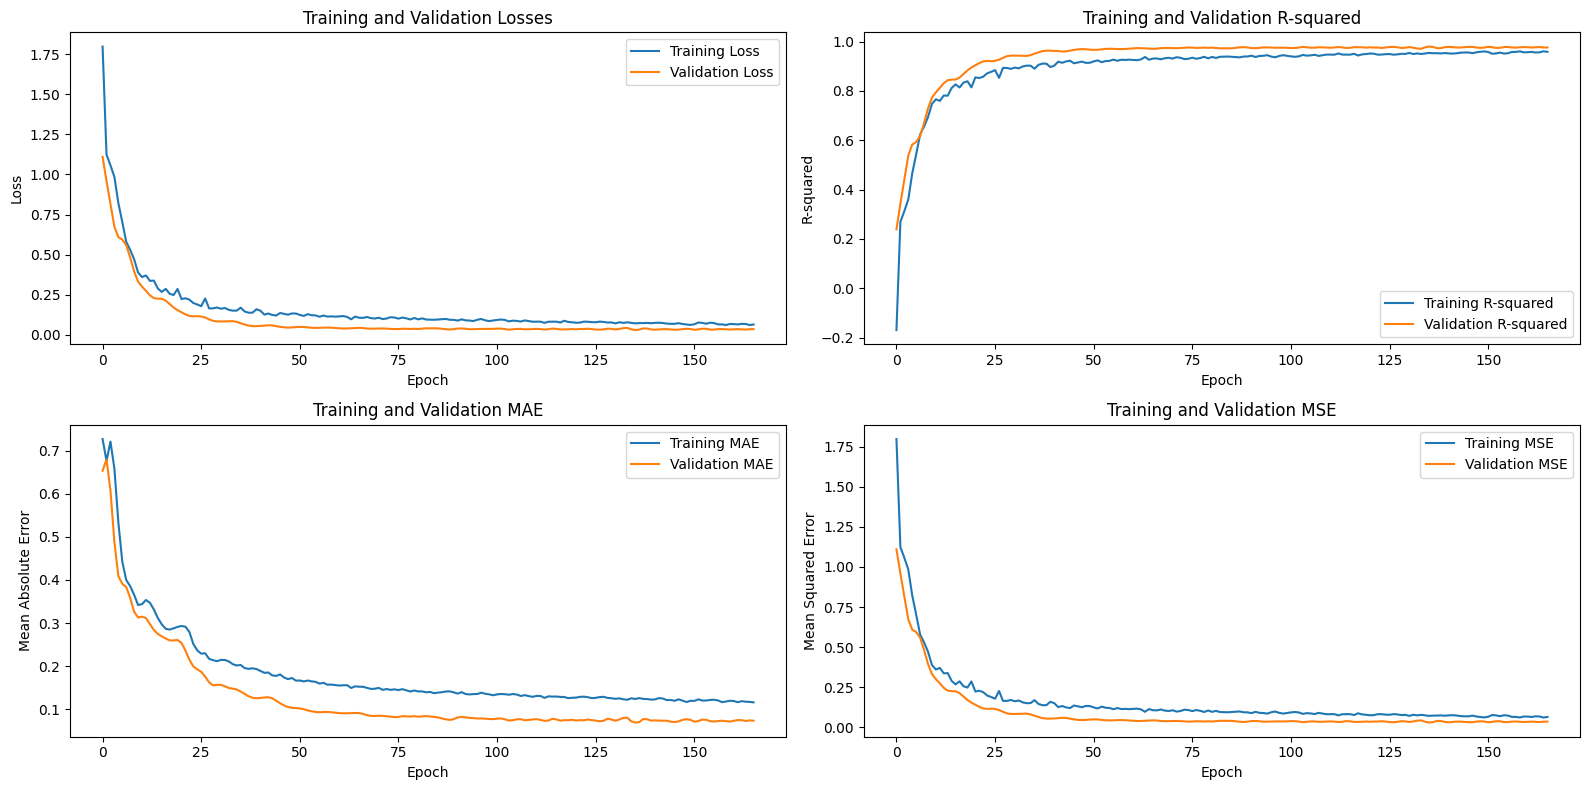

Test R-squared: 0.9770989747559549, Test MAE: 8.277580261230469, Test MSE: 465.2622375488281, Avg Test Residual: 3.6838741302490234


In [22]:
from sklearn.preprocessing import RobustScaler
import torch
from torch import optim
from torch_geometric.nn import SAGEConv
import joblib
import os
import optuna
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
os.makedirs(drive_path, exist_ok=True)
model_path = os.path.join(drive_path, 'pegnn_model_LONDON.pth')
study_path = os.path.join(drive_path, 'optuna_study_pegnn_LONDON.pkl')
input_size_path = os.path.join(drive_path, 'input_feature_size_LONDON.pkl')

# Function to save and load the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model_class, path, in_channels, hidden_channels):
    model = model_class(in_channels, hidden_channels)
    model.load_state_dict(torch.load(path))
    return model

# Function to save and load input feature size
def save_input_feature_size(size, path):
    with open(path, 'wb') as f:
        joblib.dump(size, f)

def load_input_feature_size(path):
    with open(path, 'rb') as f:
        size = joblib.load(f)
    return size

# Create edges using k-nearest neighbors
def create_edges_knn(coordinates, k=15):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coordinates)
    distances, indices = nbrs.kneighbors(coordinates)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:
                edge_index.append([i, neighbor])
                edge_index.append([neighbor, i])  # add both directions
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

# Learnable Positional Embeddings
class PositionalEncoding(torch.nn.Module):
    def __init__(self, num_positions, d_model):
        super(PositionalEncoding, self).__init__()
        self.position_embeddings = torch.nn.Parameter(torch.zeros(num_positions, d_model))

    def forward(self, positions):
        return self.position_embeddings[positions]

# PEGNN model definition with a single fully connected layer
class PEGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout_rate=0.5):
        super(PEGNN, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.out = torch.nn.Linear(hidden_channels, 1)  # Single fully connected layer with one output node

    def forward(self, x, edge_index):
        price_index = 1
        prices = x[:, price_index]

        # Mask out the node's own price during aggregation
        x_masked = x.clone()
        x_masked[:, price_index] = 0

        # Pass through the first convolutional layer with dropout
        x = self.conv1(x_masked, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Pass through the second convolutional layer
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Directly pass to the final output layer
        x = self.out(x)

        return x

d_model = 128

# Optuna objective function
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    k = trial.suggest_int('k', 1, 150)  # Hyperparameter for k-nearest neighbors
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    edge_index_train = create_edges_knn(train_coords_pegnn, k)
    edge_index_val = create_edges_knn(val_coords_pegnn, k)
    edge_index_test = create_edges_knn(test_coords_pegnn, k)

    positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
    pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
    pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
    pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

    x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
    x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
    x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

    model = PEGNN(in_channels=x_train.shape[1], hidden_channels=hidden_channels, dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # L2 regularization with weight_decay
    loss_fn = torch.nn.MSELoss()

    model.train()
    for epoch in tqdm(range(50), desc="Training PEGNN"):
        optimizer.zero_grad()
        out_train = model(x_train, edge_index_train)
        loss = loss_fn(out_train, y_train)
        loss.backward(retain_graph=True)
        optimizer.step()

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)

    return val_loss.item()

# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Save the study
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

best_params = study.best_params
print("Best parameters: ", best_params)

# Final training with best parameters
edge_index_train = create_edges_knn(train_coords_pegnn, best_params['k'])
edge_index_val = create_edges_knn(val_coords_pegnn, best_params['k'])
edge_index_test = create_edges_knn(test_coords_pegnn, best_params['k'])

positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

# Save input feature size
input_feature_size = x_train.shape[1]
save_input_feature_size(input_feature_size, input_size_path)

model = PEGNN(in_channels=input_feature_size, hidden_channels=best_params['hidden_channels'], dropout_rate=best_params['dropout_rate'])
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=1e-4)  # L2 regularization with weight_decay
loss_fn = torch.nn.MSELoss()

train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
train_mae_scores = []
val_mae_scores = []
train_mse_scores = []
val_mse_scores = []

# Early stopping parameters
patience = 30
best_val_loss = float('inf')
patience_counter = 0

model.train()
for epoch in tqdm(range(500), desc="Final training"):
    optimizer.zero_grad()
    out_train = model(x_train, edge_index_train)
    loss = loss_fn(out_train, y_train)
    loss.backward(retain_graph=True)
    optimizer.step()
    train_losses.append(loss.item())

    y_train_np = y_train.detach().numpy()
    out_train_np = out_train.detach().numpy()
    train_r2 = r2_score(y_train_np, out_train_np)
    train_mae = mean_absolute_error(y_train_np, out_train_np)
    train_mse = mean_squared_error(y_train_np, out_train_np)
    train_r2_scores.append(train_r2)
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)

    print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}, Training R-squared: {train_r2}, Training MAE: {train_mae}, Training MSE: {train_mse}')

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)
        val_losses.append(val_loss.item())

        y_val_np = y_val.detach().numpy()
        out_val_np = out_val.detach().numpy()
        val_r2 = r2_score(y_val_np, out_val_np)
        val_mae = mean_absolute_error(y_val_np, out_val_np)
        val_mse = mean_squared_error(y_val_np, out_val_np)
        val_r2_scores.append(val_r2)
        val_mae_scores.append(val_mae)
        val_mse_scores.append(val_mse)

    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss.item()}, Validation R-squared: {val_r2}, Validation MAE: {val_mae}, Validation MSE: {val_mse}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        save_model(model, model_path)
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break

    model.train()

# Plotting
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(2, 2, 2)
plt.plot(train_r2_scores, label='Training R-squared')
plt.plot(val_r2_scores, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.legend()
plt.title('Training and Validation R-squared')

plt.subplot(2, 2, 3)
plt.plot(train_mae_scores, label='Training MAE')
plt.plot(val_mae_scores, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.subplot(2, 2, 4)
plt.plot(train_mse_scores, label='Training MSE')
plt.plot(val_mse_scores, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')

plt.tight_layout()
plt.show()

# Rescale predictions and targets for final evaluation
model.eval()
with torch.no_grad():
    out_train = model(x_train, edge_index_train)
    out_val = model(x_val, edge_index_val)
    out_test = model(x_test, edge_index_test)

# Inverse transform the predictions and actual values
out_train_rescaled = scaler.inverse_transform(out_train.numpy())
y_train_rescaled = scaler.inverse_transform(y_train.numpy())

out_val_rescaled = scaler.inverse_transform(out_val.numpy())
y_val_rescaled = scaler.inverse_transform(y_val.numpy())

out_test_rescaled = scaler.inverse_transform(out_test.numpy())
y_test_rescaled = scaler.inverse_transform(y_test.numpy())

# Compute metrics on the original scale
train_r2 = r2_score(y_train_rescaled, out_train_rescaled)
train_mae = mean_absolute_error(y_train_rescaled, out_train_rescaled)
train_mse = mean_squared_error(y_train_rescaled, out_train_rescaled)

val_r2 = r2_score(y_val_rescaled, out_val_rescaled)
val_mae = mean_absolute_error(y_val_rescaled, out_val_rescaled)
val_mse = mean_squared_error(y_val_rescaled, out_val_rescaled)

test_r2 = r2_score(y_test_rescaled, out_test_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, out_test_rescaled)
test_mse = mean_squared_error(y_test_rescaled, out_test_rescaled)
test_residuals_avg = np.mean(y_test_rescaled - out_test_rescaled)
print(f'Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}, Avg Test Residual: {test_residuals_avg}')


extra reporting metrics


Test Loss: 0.03502804785966873, Test R-squared: 0.9770989747559549, Test MAE: 8.277580261230469, Test MSE: 465.2622375488281


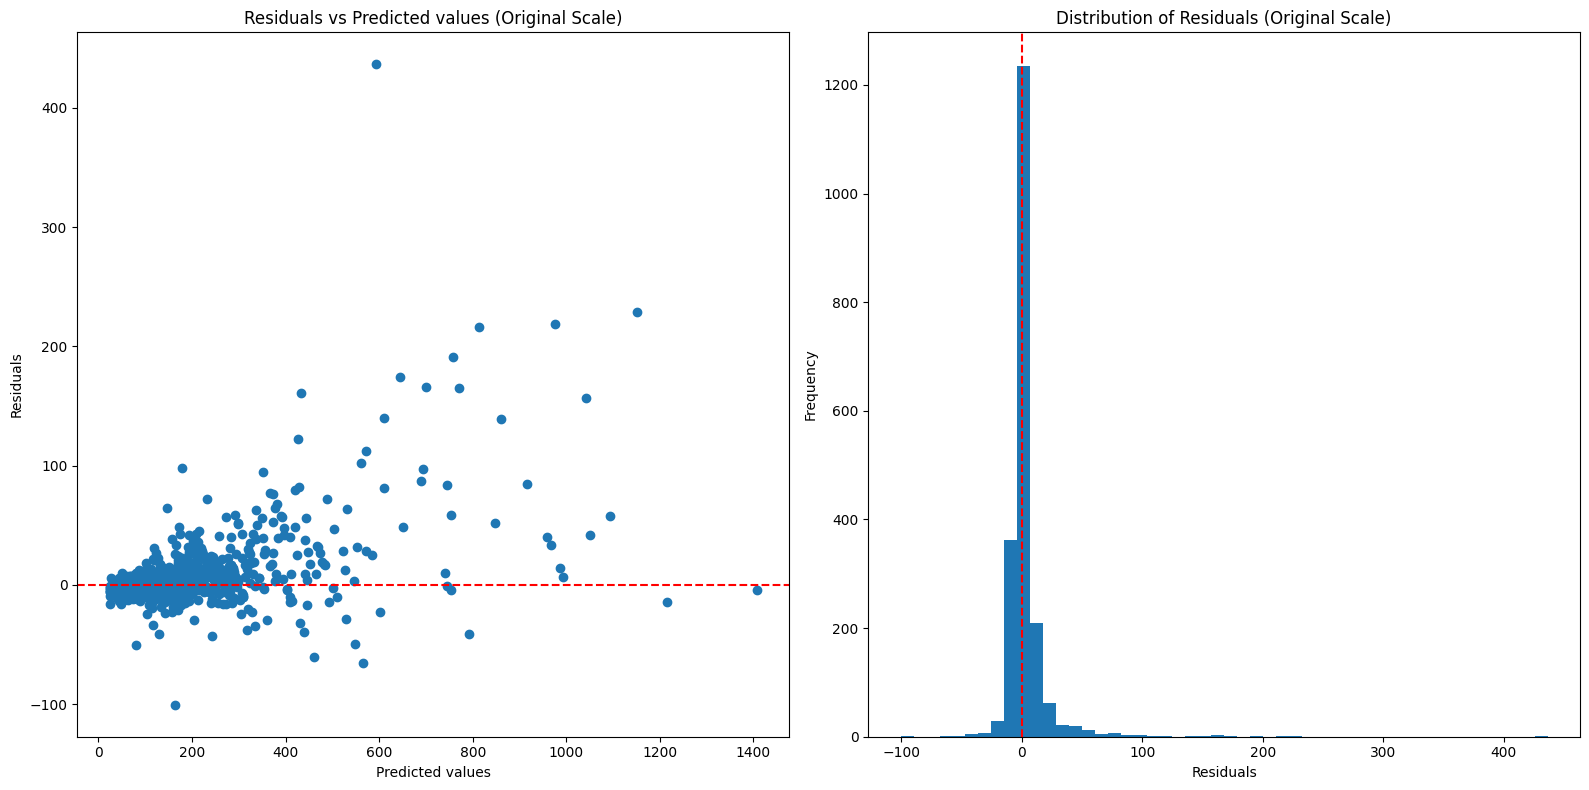

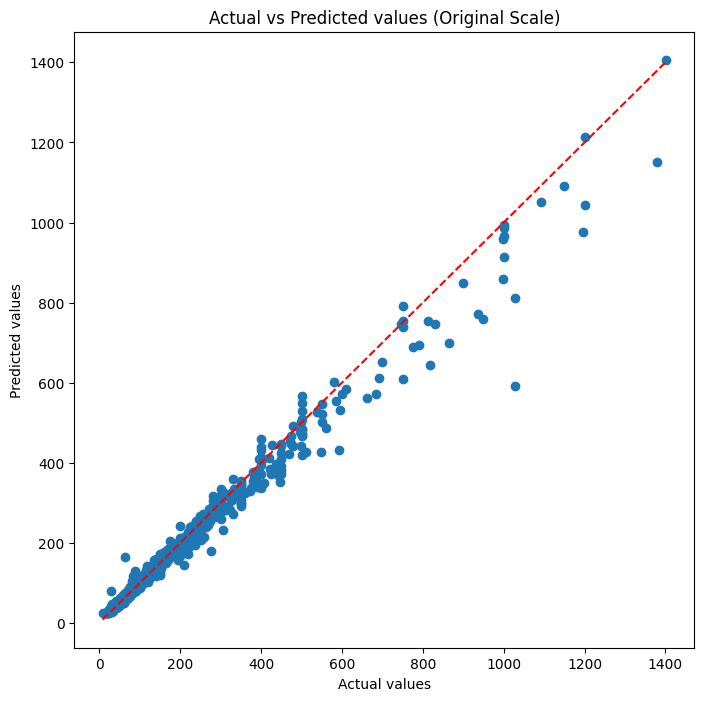

In [23]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    out_test = model(x_test, edge_index_test)
    test_loss = loss_fn(out_test, y_test)
    y_test_np = y_test.detach().numpy()
    out_test_np = out_test.detach().numpy()

# Inverse transform the predictions and actual values
y_test_rescaled = scaler.inverse_transform(y_test_np)
out_test_rescaled = scaler.inverse_transform(out_test_np)

# Calculate evaluation metrics on the original scale
test_r2 = r2_score(y_test_rescaled, out_test_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, out_test_rescaled)
test_mse = mean_squared_error(y_test_rescaled, out_test_rescaled)

print(f'Test Loss: {test_loss.item()}, Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}')

# Calculate residuals in the original scale
residuals_rescaled = y_test_rescaled - out_test_rescaled

# Plotting residuals
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.scatter(out_test_rescaled, residuals_rescaled)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values (Original Scale)')
plt.axhline(0, color='red', linestyle='--')

plt.subplot(1, 2, 2)
plt.hist(residuals_rescaled, bins=50)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Original Scale)')
plt.axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Plotting predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_rescaled, out_test_rescaled)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values (Original Scale)')
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color='red', linestyle='--')
plt.show()


Text(0.5, 1.0, 'Heatmap of Predicted Prices')

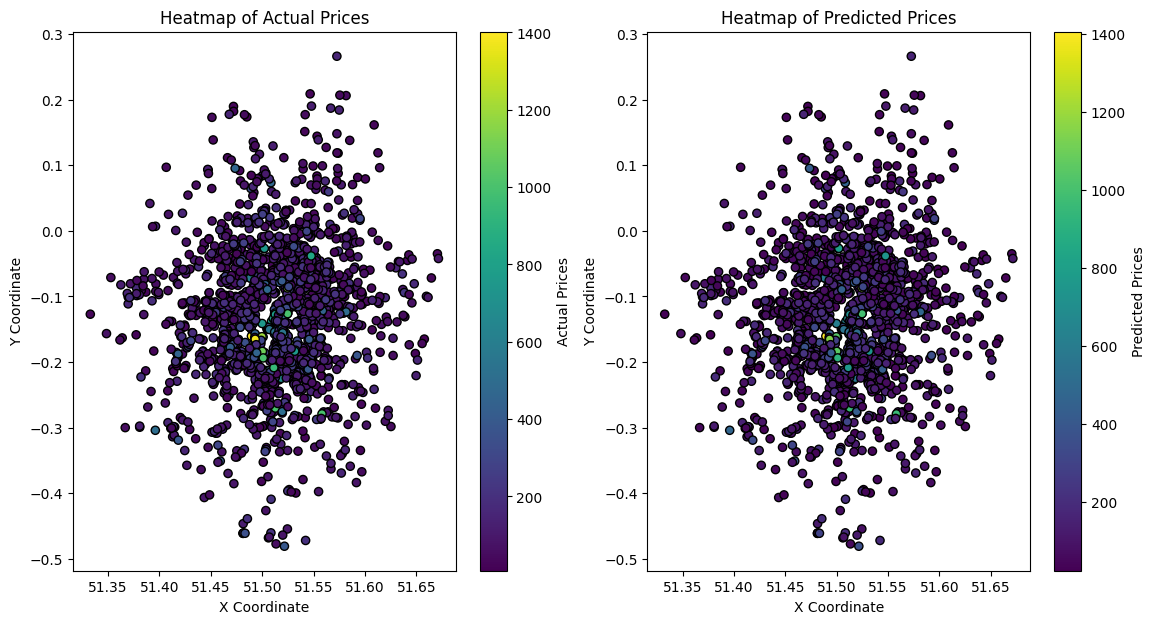

In [24]:
import seaborn as sns

# Assuming 'coords_np' contains the coordinates and 'scaler' is used for inverse transformation
coords_np = np.array(test_coords_pegnn)

# Rescale the actual and predicted prices to original scale
y_test_rescaled = scaler.inverse_transform(y_test_np)
out_test_rescaled = scaler.inverse_transform(out_test_np)
residuals_rescaled = y_test_rescaled - out_test_rescaled

plt.figure(figsize=(21, 7))

# Heatmap of Actual Prices
plt.subplot(1, 3, 1)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=y_test_rescaled.flatten(), cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Actual Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Actual Prices')

# Heatmap of Predicted Prices
plt.subplot(1, 3, 2)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=out_test_rescaled.flatten(), cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Predicted Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Predicted Prices')


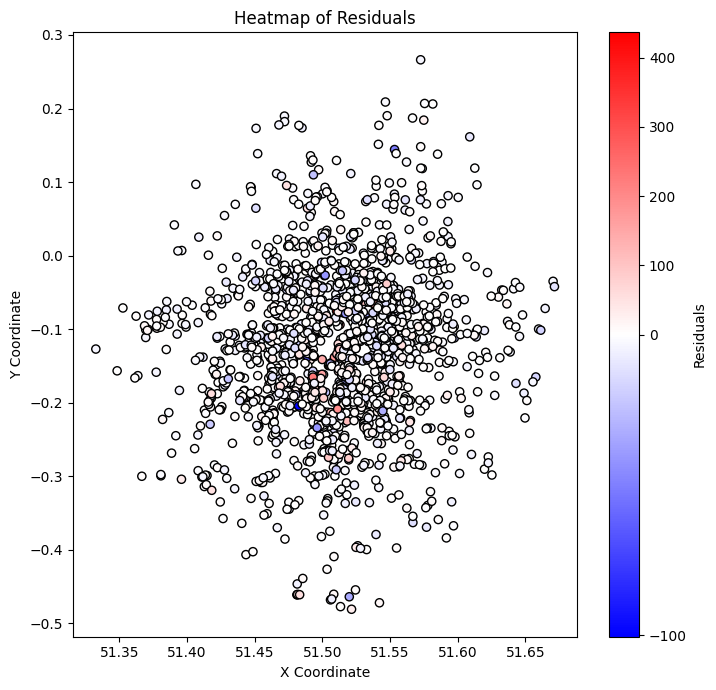

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm



# Define a custom colormap with 0 as white
cmap = LinearSegmentedColormap.from_list('custom_coolwarm',
                                         [(0, 'blue'),
                                          (0.5, 'white'),
                                          (1, 'red')], N=256)

# Normalize the data so that 0 maps to white
norm = TwoSlopeNorm(vmin=residuals_rescaled.min(), vcenter=0, vmax=residuals_rescaled.max())

# Create the plot
plt.figure(figsize=(21, 7))

# Heatmap of Residuals
plt.subplot(1, 3, 3)
sc = plt.scatter(coords_np[:, 0], coords_np[:, 1], c=residuals_rescaled.flatten(), cmap=cmap, norm=norm, s=35, edgecolor='k')
plt.colorbar(sc, label='Residuals')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Residuals')

plt.tight_layout()
plt.show()


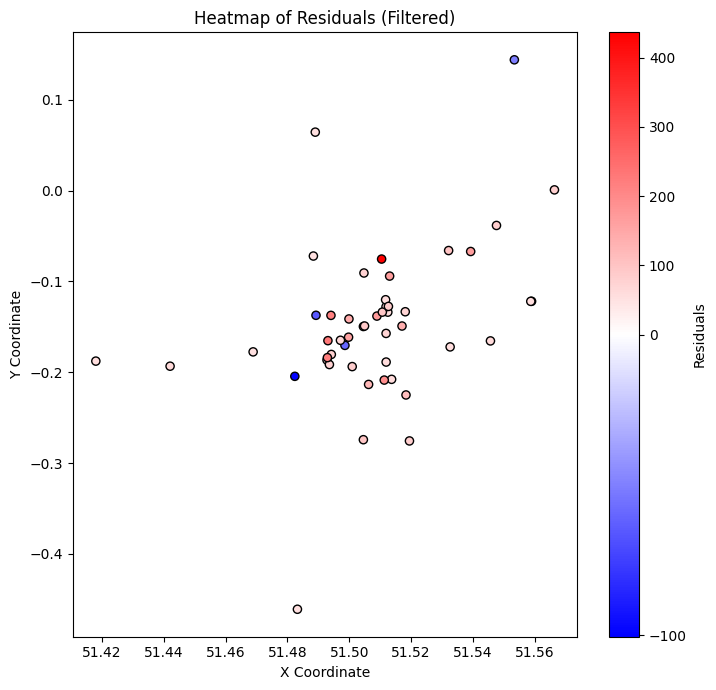

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# Assuming residuals_rescaled and coords_np are already defined

# Define a custom colormap with 0 as white
cmap = LinearSegmentedColormap.from_list('custom_coolwarm',
                                         [(0, 'blue'),
                                          (0.5, 'white'),
                                          (1, 'red')], N=256)

# Normalize the data so that 0 maps to white
norm = TwoSlopeNorm(vmin=residuals_rescaled.min(), vcenter=0, vmax=residuals_rescaled.max())

# Filter out residuals between -50 and 50
mask = (residuals_rescaled < -50) | (residuals_rescaled > 50)
filtered_coords = coords_np[mask.flatten()]
filtered_residuals = residuals_rescaled[mask]

# Create the plot
plt.figure(figsize=(21, 7))

# Heatmap of Residuals
plt.subplot(1, 3, 3)
sc = plt.scatter(filtered_coords[:, 0], filtered_coords[:, 1], c=filtered_residuals.flatten(), cmap=cmap, norm=norm, s=35, edgecolor='k')
plt.colorbar(sc, label='Residuals')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Residuals (Filtered)')

plt.tight_layout()
plt.show()


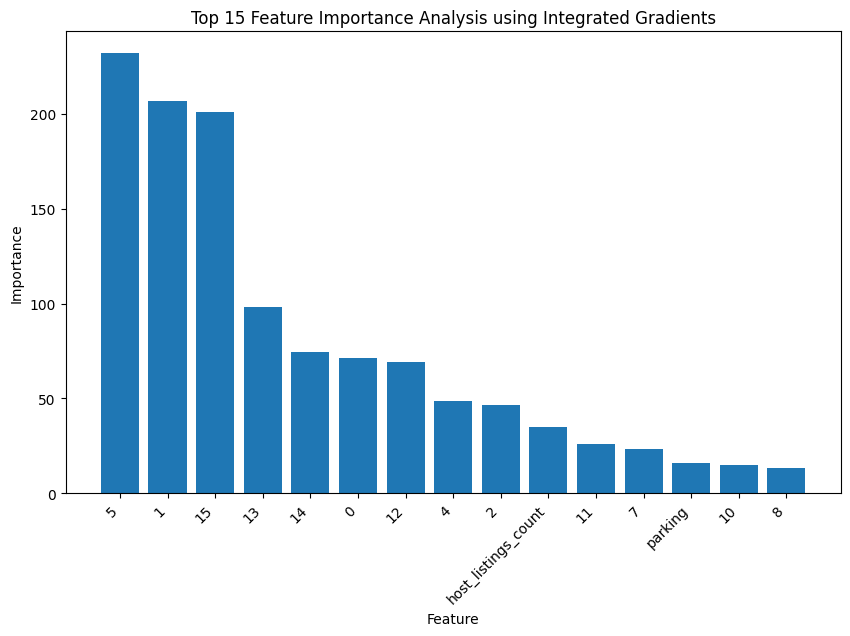

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

feature_names = train_features_pegnn.columns.tolist()

def integrated_gradients(model, inputs, edge_index, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads = []

    for input_ in scaled_inputs:
        input_ = Variable(input_, requires_grad=True)
        output = model(input_, edge_index)
        target = output[:, target_class].sum()
        target.backward(retain_graph=True)
        grads.append(input_.grad.cpu().detach().numpy())

    grads = np.array(grads)
    avg_grads = np.mean(grads[:-1], axis=0)
    integrated_grads = (inputs.cpu().detach().numpy() - baseline.cpu().detach().numpy()) * avg_grads

    return integrated_grads

# Assuming model, x_test, edge_index_test, y_test, and feature_names are already defined

inputs = x_test  # Use all node features in the graph
baseline = torch.zeros_like(inputs)
target_class = 0  # Assuming the target class is the first output
integrated_grads = integrated_gradients(model, inputs, edge_index_test, target_class, baseline)

overall_feature_importances = np.sum(integrated_grads, axis=0)

# Get the top 15 features
top_features_idx = np.argsort(overall_feature_importances)[-15:][::-1]
top_features = [feature_names[i] for i in top_features_idx]
top_importances = overall_feature_importances[top_features_idx]

# Visualize top 15 feature importances
plt.figure(figsize=(10, 6))
plt.bar(top_features, top_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 15 Feature Importance Analysis using Integrated Gradients')
plt.xticks(rotation=45, ha='right')
plt.show()


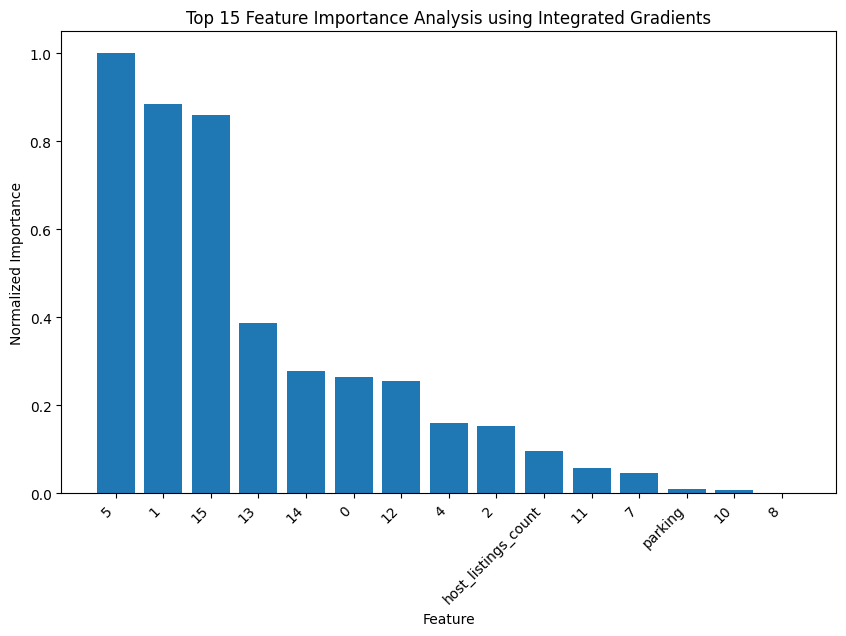

Top 15 Feature Importances (Normalized):
5: 1.0000
1: 0.8848
15: 0.8589
13: 0.3874
14: 0.2784
0: 0.2649
12: 0.2547
4: 0.1605
2: 0.1520
host_listings_count: 0.0974
11: 0.0568
7: 0.0452
parking: 0.0110
10: 0.0072
8: 0.0000


In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

# Assuming train_features_pegnn, model, x_test, edge_index_test, and y_test are already defined

feature_names = train_features_pegnn.columns.tolist()

def integrated_gradients(model, inputs, edge_index, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads = []

    for input_ in scaled_inputs:
        input_ = Variable(input_, requires_grad=True)
        output = model(input_, edge_index)
        target = output[:, target_class].sum()
        target.backward(retain_graph=True)
        grads.append(input_.grad.cpu().detach().numpy())

    grads = np.array(grads)
    avg_grads = np.mean(grads[:-1], axis=0)
    integrated_grads = (inputs.cpu().detach().numpy() - baseline.cpu().detach().numpy()) * avg_grads

    return integrated_grads

# Get the inputs and baseline for the entire graph
inputs = x_test  # Use all node features in the graph
baseline = torch.zeros_like(inputs)

# Compute Integrated Gradients for each node in the graph
target_class = 0  # Assuming the target class is the first output
integrated_grads = integrated_gradients(model, inputs, edge_index_test, target_class, baseline)

# Summing up the attributions for all nodes to get overall feature importances
overall_feature_importances = np.sum(integrated_grads, axis=0)

# Get the top 15 features
top_features_idx = np.argsort(overall_feature_importances)[-15:][::-1]
top_features = [feature_names[i] for i in top_features_idx]
top_importances = overall_feature_importances[top_features_idx]

# Normalize the top 15 feature importances to the range [0, 1]
min_importance = np.min(top_importances)
max_importance = np.max(top_importances)
normalized_importances = (top_importances - min_importance) / (max_importance - min_importance)

# Visualize top 15 feature importances
plt.figure(figsize=(10, 6))
plt.bar(top_features, normalized_importances)
plt.xlabel('Feature')
plt.ylabel('Normalized Importance')
plt.title('Top 15 Feature Importance Analysis using Integrated Gradients')
plt.xticks(rotation=45, ha='right')
plt.show()

# Create a DataFrame for the top 15 features and their normalized importances
feature_importances_df = pd.DataFrame({
    'Feature': top_features,
    'Normalized Importance': normalized_importances
})

# Save the DataFrame to a CSV file
# Specify the path in Google Drive where you want to save the files
path = '/content/drive/My Drive/THESIS/'

# Save the processed data to CSV files
feature_importances_df.to_csv(path + 'feature_importances_with_lstm_london.csv', index=False)
# Display the list of top 15 features with their normalized importances
print("Top 15 Feature Importances (Normalized):")
for feature, importance in zip(top_features, normalized_importances):
    print(f"{feature}: {importance:.4f}")